In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
path = '../../data/processed/merged_mbta_weather.csv'
df = pd.read_csv(path)
print(df.head())

  service_date station_name  gated_entries  tavg  tmin  tmax  prcp  wspd
0   2018-01-01      Airport         3236.0 -14.7 -17.7 -10.5   0.0  26.3
1   2018-01-01      Alewife         1416.0 -14.7 -17.7 -10.5   0.0  26.3
2   2018-01-01       Andrew         1310.0 -14.7 -17.7 -10.5   0.0  26.3
3   2018-01-01     Aquarium         1801.0 -14.7 -17.7 -10.5   0.0  26.3
4   2018-01-01    Arlington         1576.0 -14.7 -17.7 -10.5   0.0  26.3


In [23]:
for i in df.columns:
    print(i)
    print(df[i].value_counts())
    print()

service_date
service_date
2022-12-20    71
2023-01-21    71
2023-02-01    71
2023-01-31    71
2023-01-30    71
              ..
2019-10-19    48
2019-11-16    47
2019-11-17    47
2019-12-08    47
2019-12-07    46
Name: count, Length: 1886, dtype: int64

station_name
station_name
Kenmore            1886
Arlington          1886
Park Street        1886
State Street       1886
Boylston           1886
                   ... 
Gilman Square        82
Magoun Square        80
Medford/Tufts        80
Ball Square          80
East Somerville      79
Name: count, Length: 71, dtype: int64

gated_entries
gated_entries
1.00000        149
2.00000        122
3.00000        120
7.00000         89
6.00000         87
              ... 
25952.00000      1
14134.00000      1
17127.00000      1
15324.00000      1
2420.83332       1
Name: count, Length: 17143, dtype: int64

tavg
tavg
10.3    937
5.6     892
5.9     889
1.7     887
10.9    880
       ... 
28.8     62
30.3     61
31.5     61
28.5     61
31.0    

In [24]:
df.describe()

,gated_entries,tavg,tmin,tmax,prcp,wspd
count,118892.000000,118892.000000,118892.000000,118892.000000,118892.000000,118892.000000
mean,4086.116150,11.581132,7.547982,15.848443,3.111387,17.762187
std,4155.002463,9.499311,9.330450,10.161044,7.557941,6.116363
min,0.000000,-17.800000,-23.300000,-12.100000,0.000000,2.500000
25%,1296.000000,3.900000,0.000000,7.200000,0.000000,13.700000
50%,2754.000000,10.900000,7.200000,15.600000,0.000000,16.900000
75%,5544.000000,20.000000,16.100000,23.900000,2.000000,21.200000
max,33670.000000,32.300000,28.300000,37.800000,68.100000,61.200000


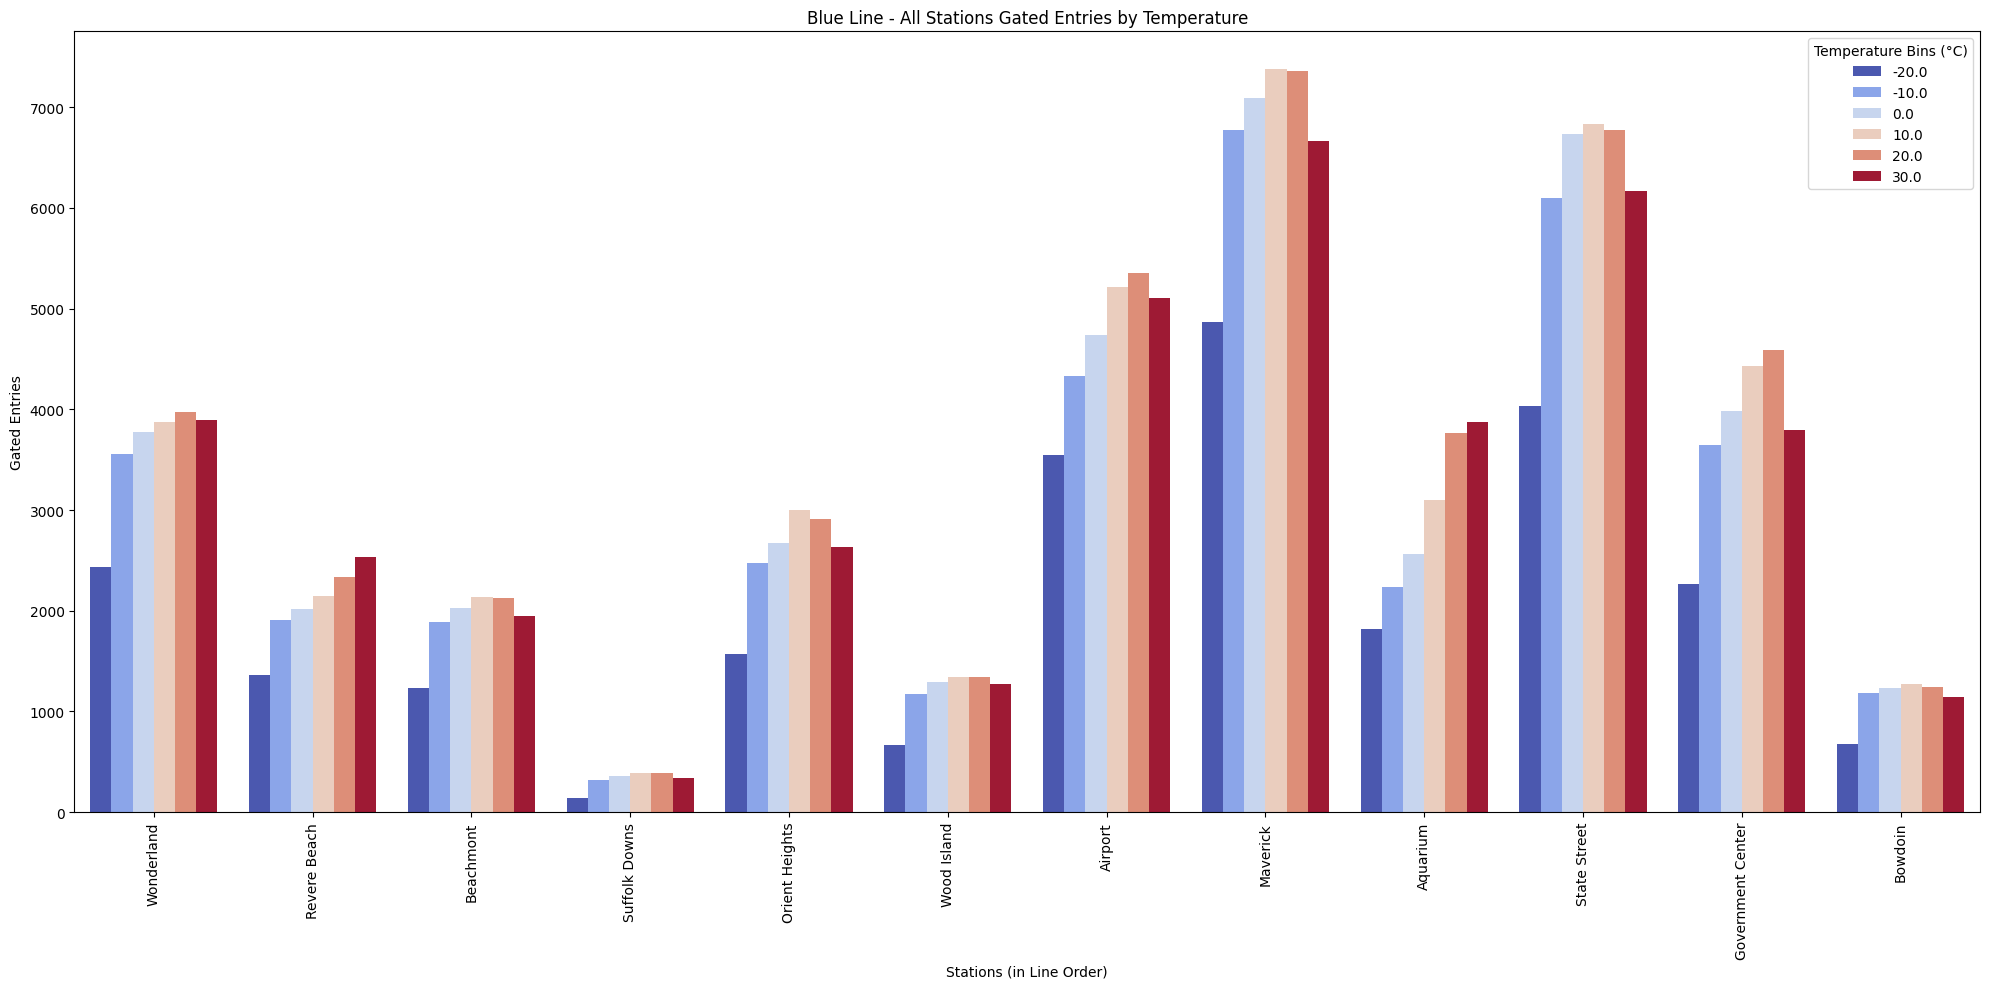

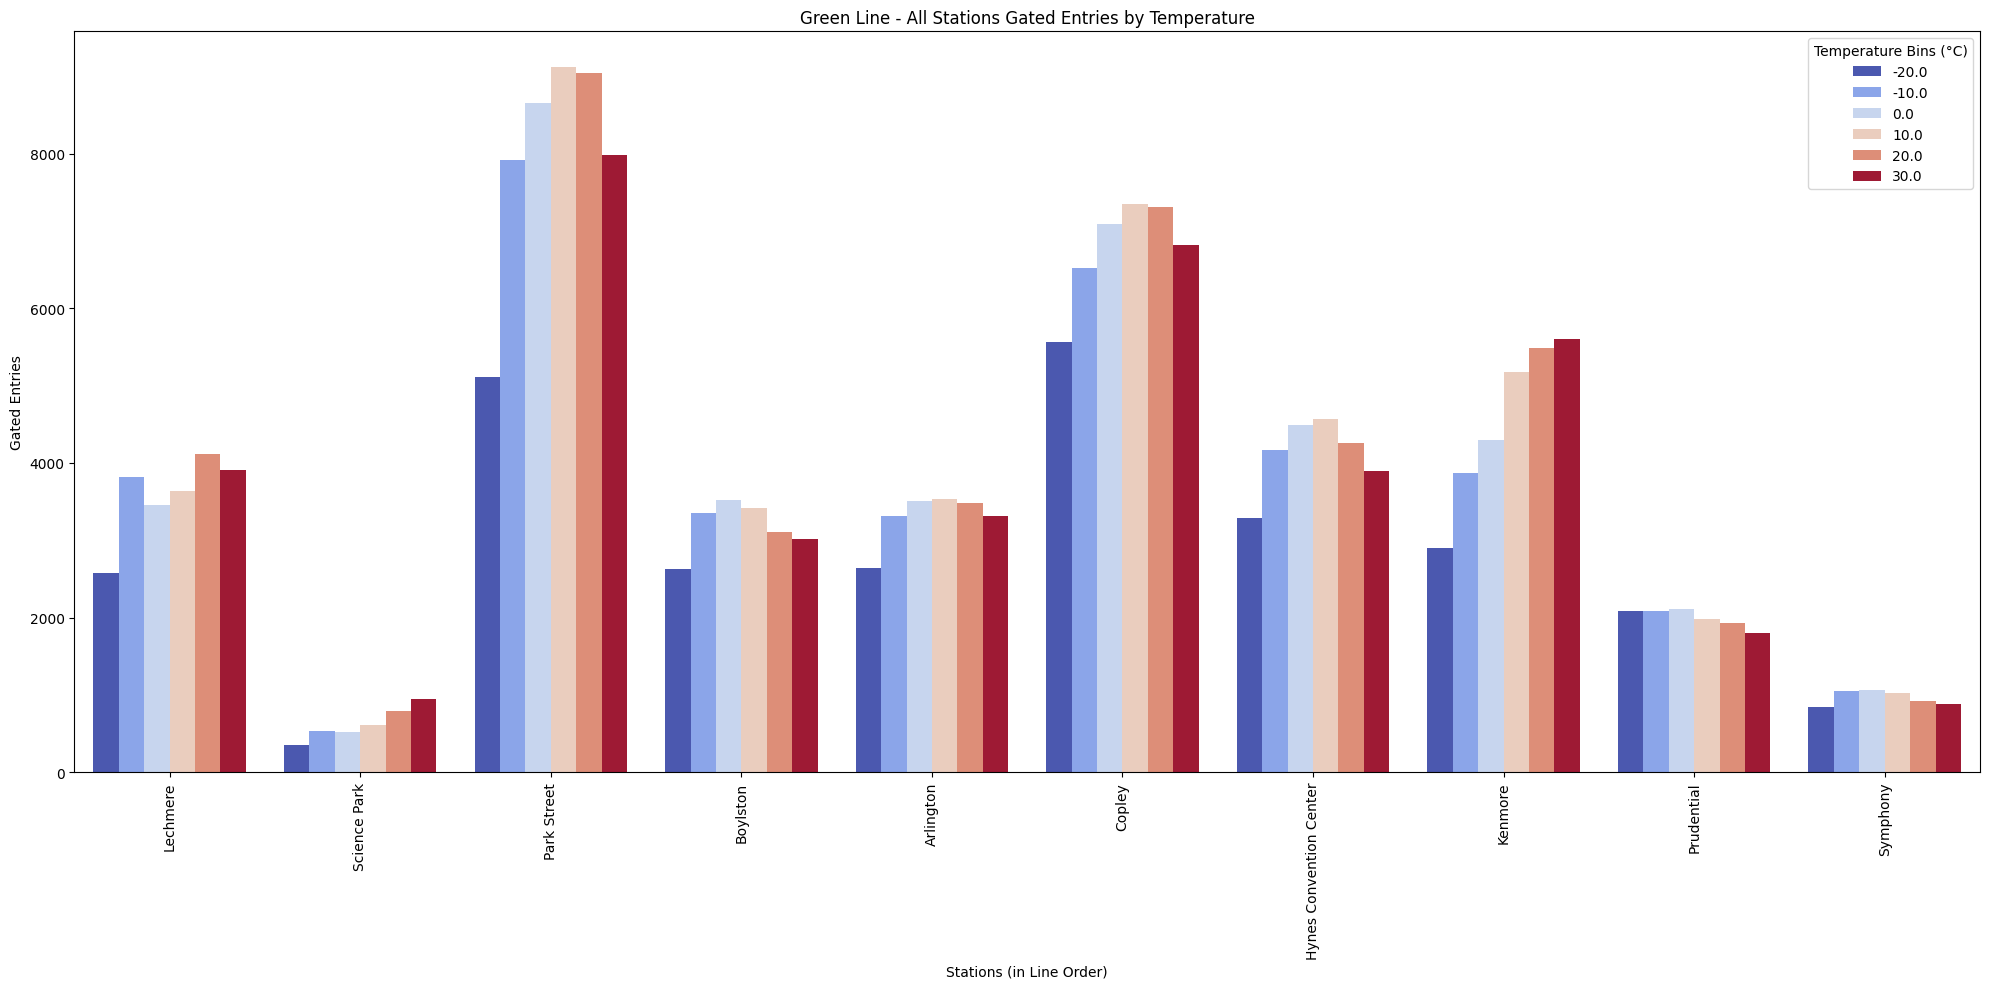

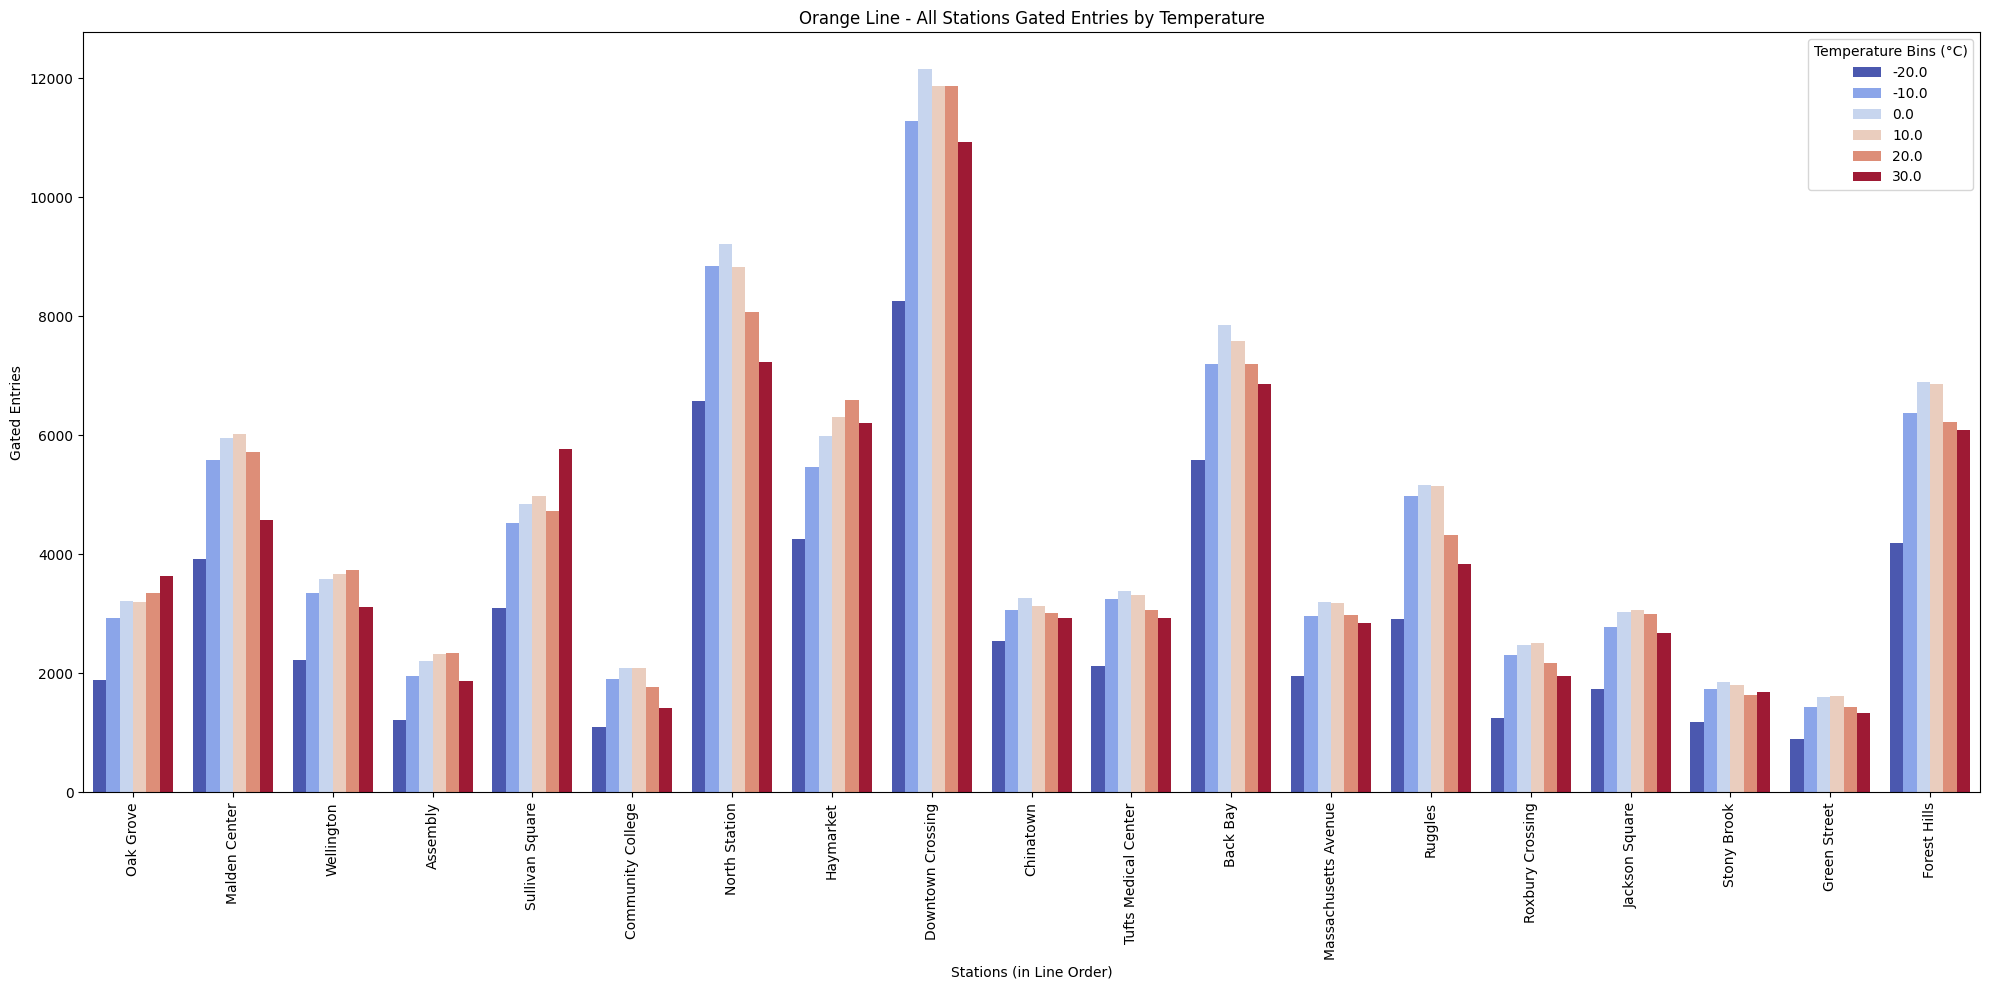

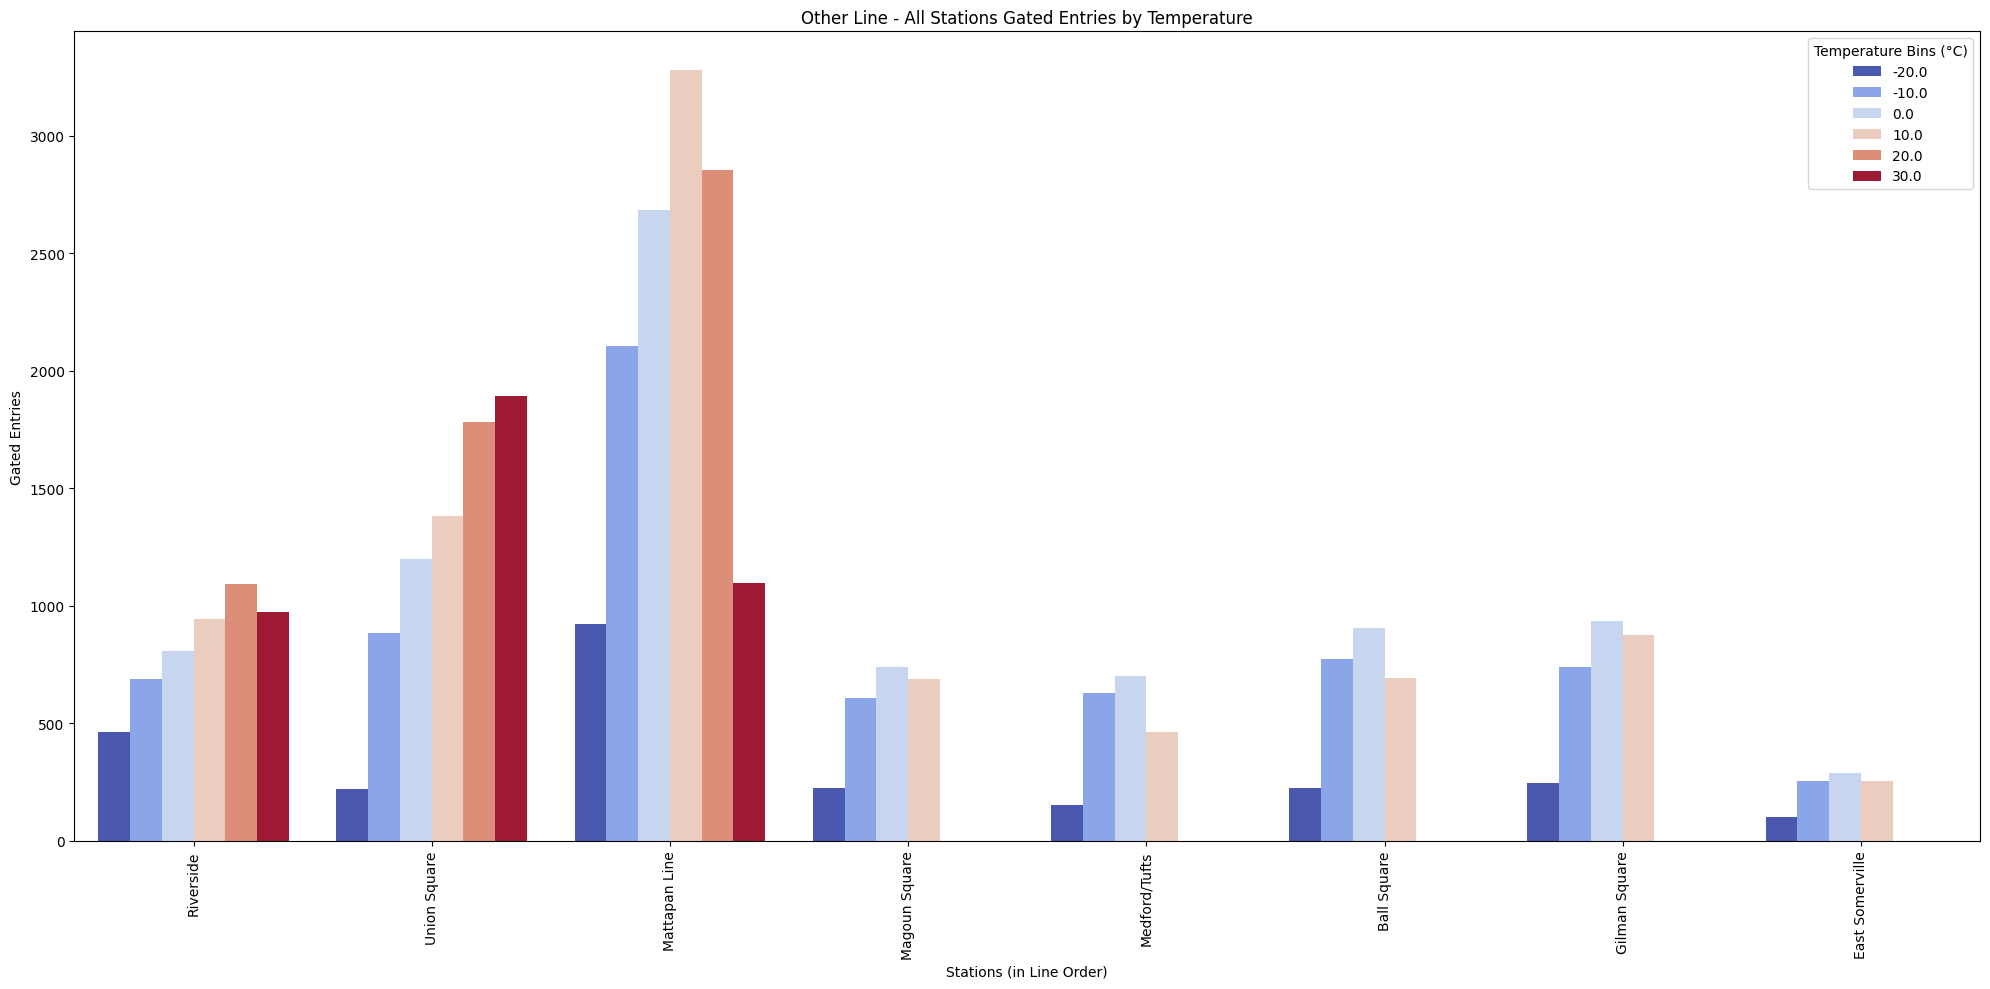

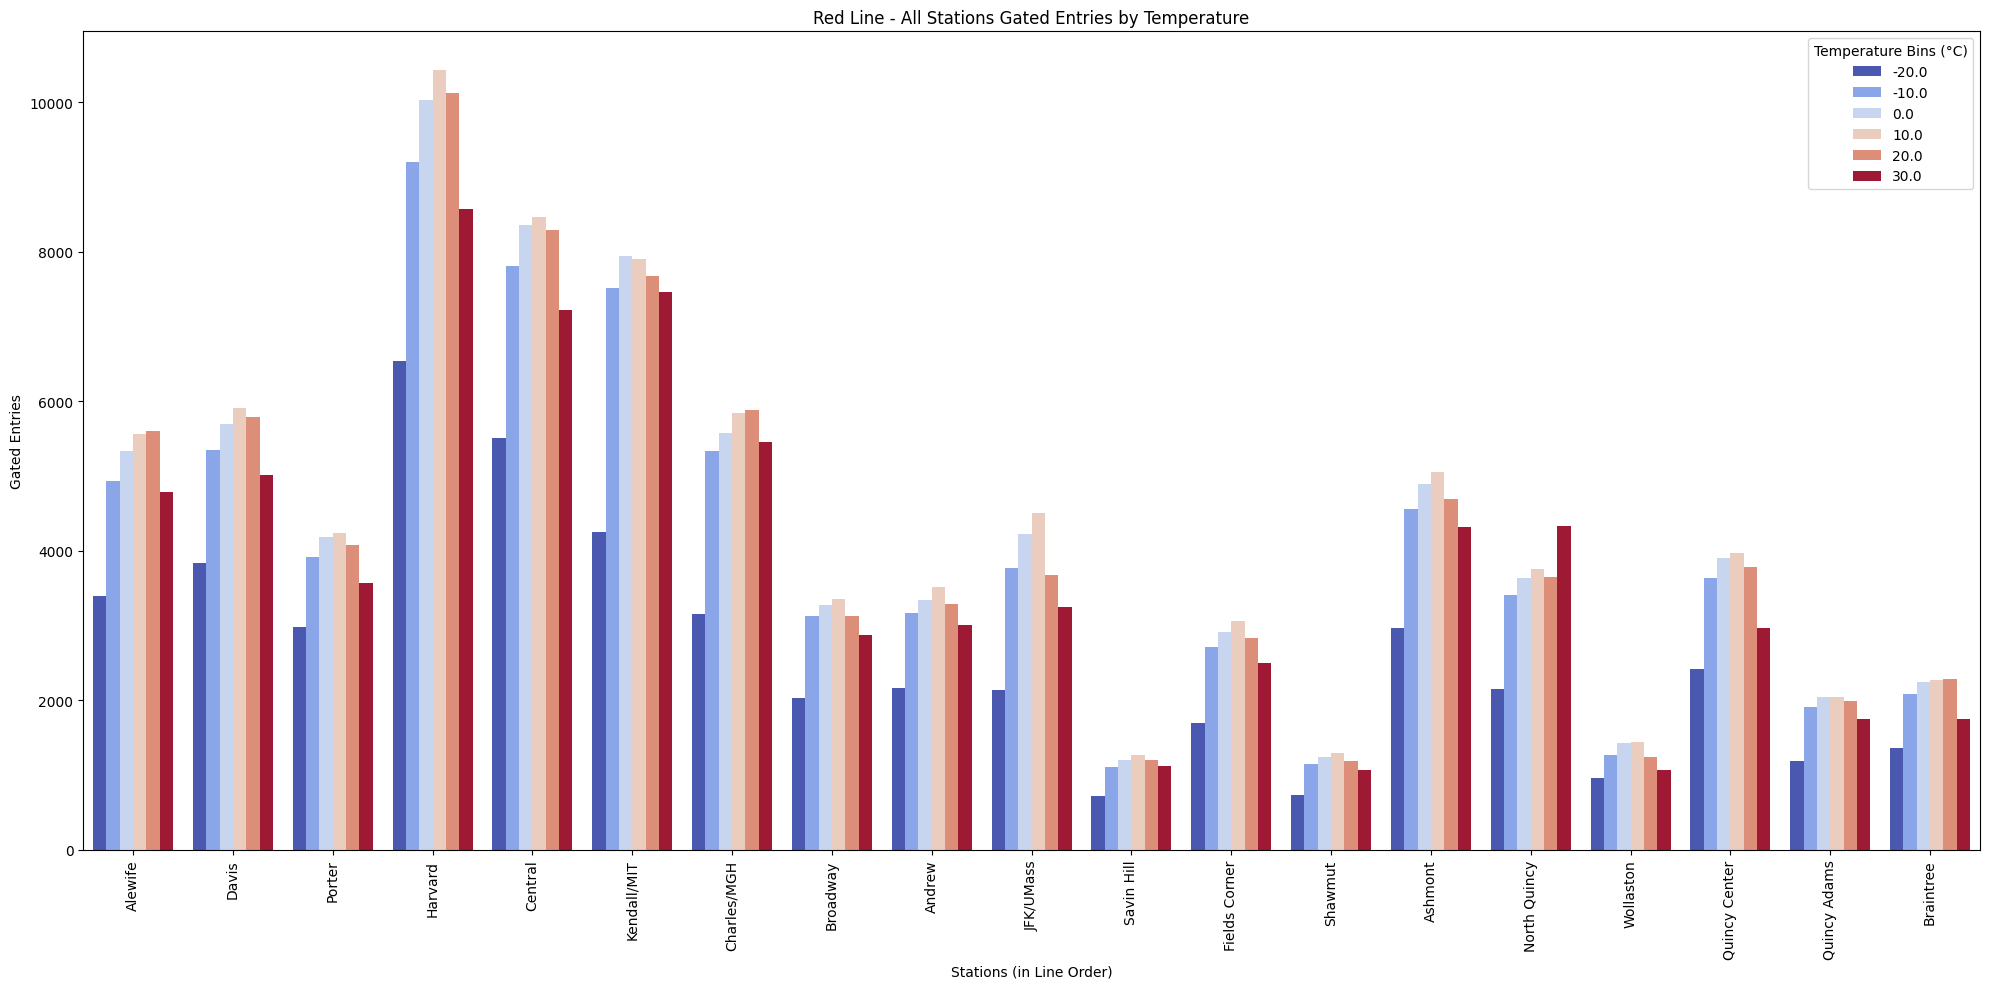

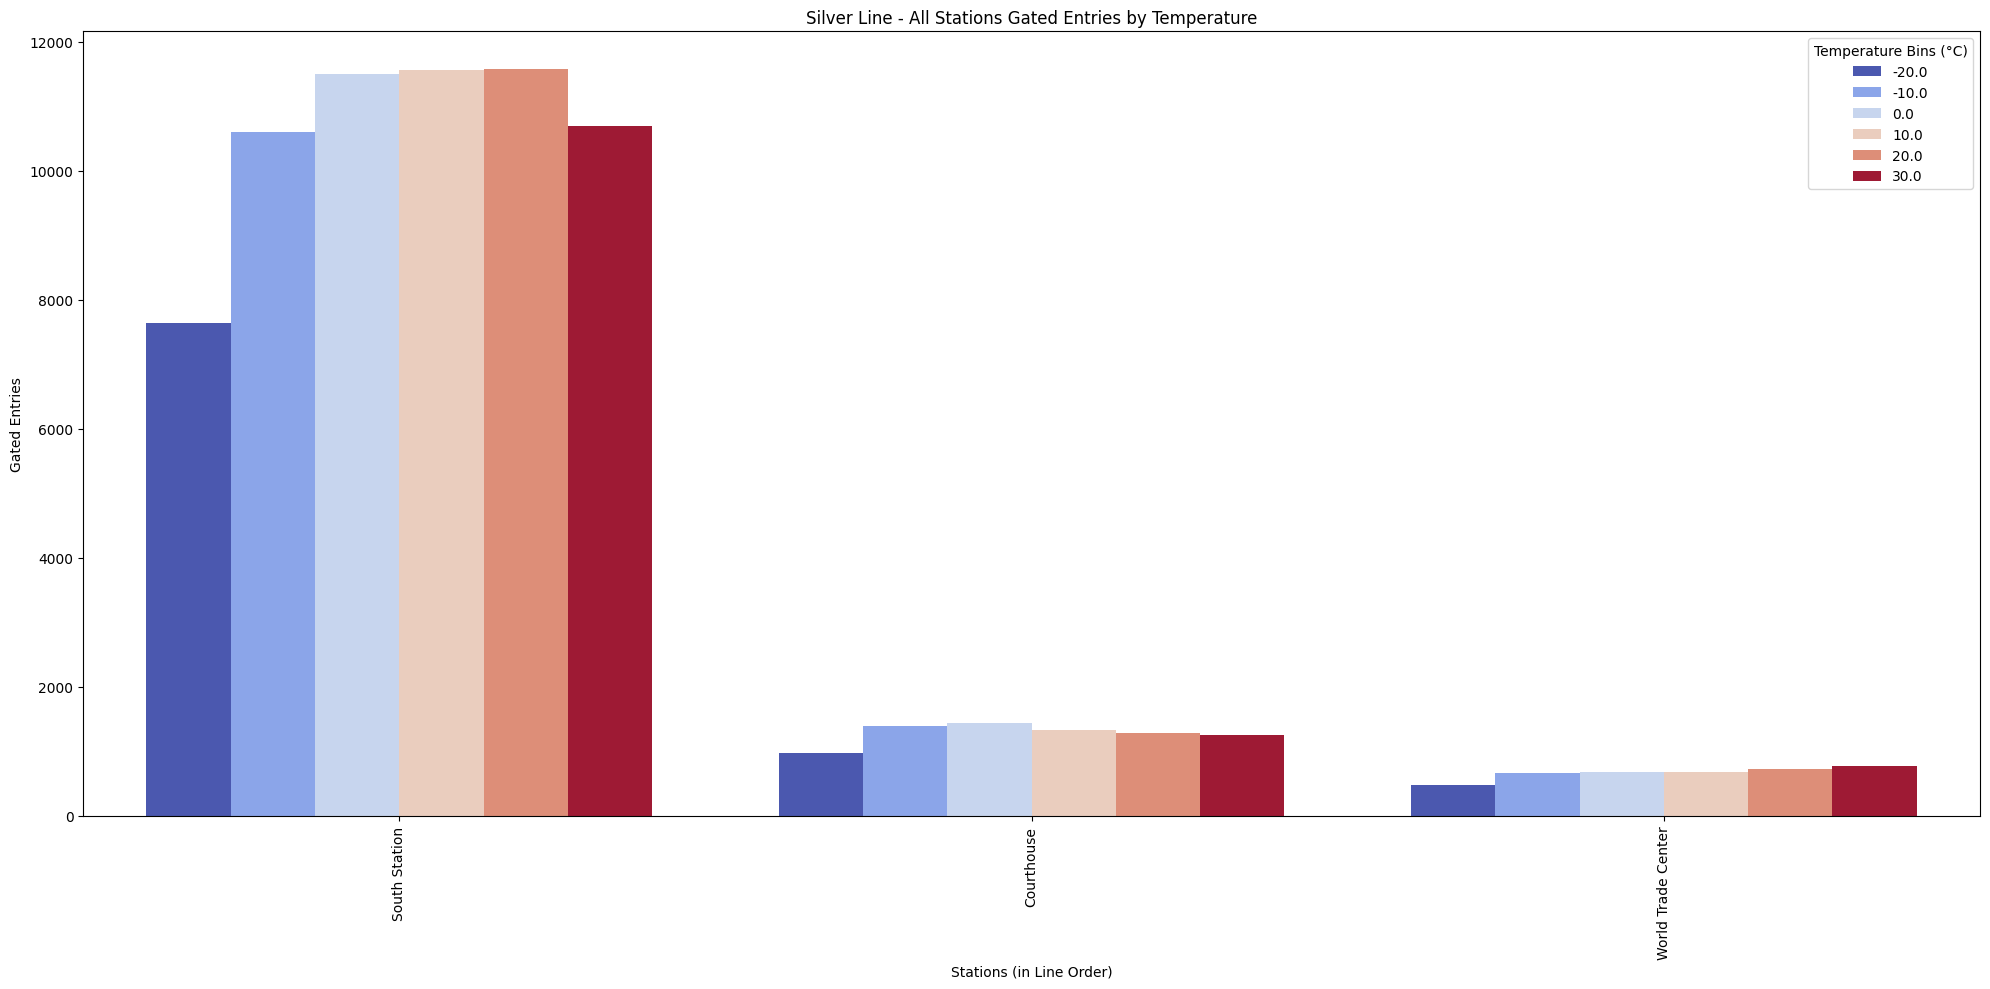

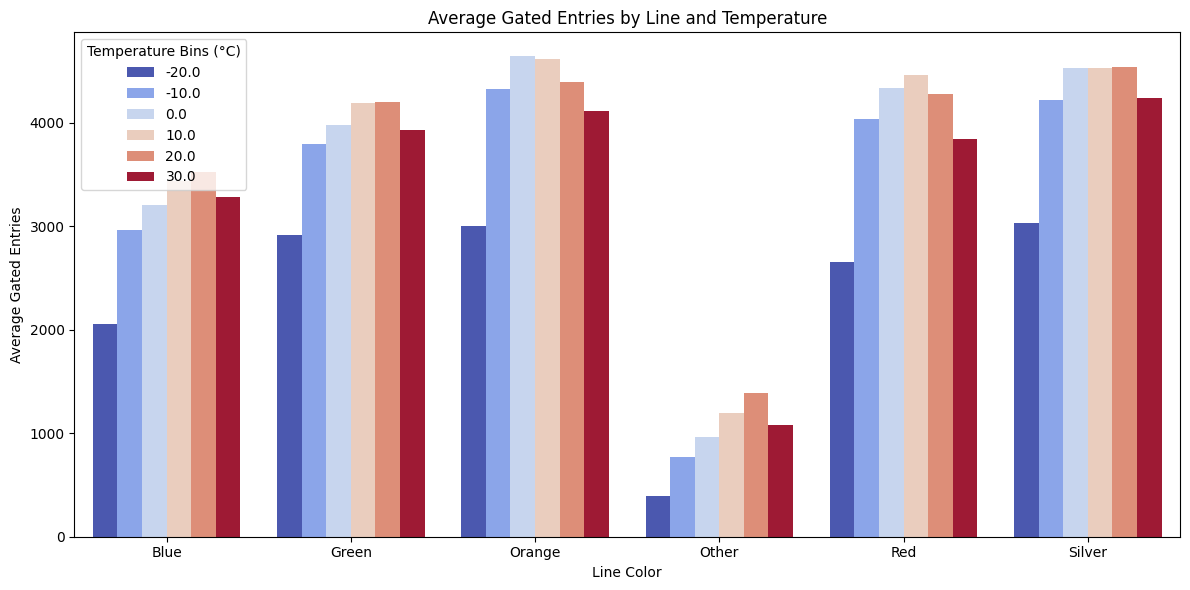

In [32]:
# Create bins for tavg in steps of 10 degrees
df["tavg_bin"] = (df["tavg"] // 10) * 10  # Grouping by 10-degree bins

# Define MBTA line colors and their stations (in actual line order)
line_colors = {
    'Red': ['Alewife', 'Davis', 'Porter', 'Harvard', 'Central', 'Kendall', 'Charles/MGH', 'Park Street', 
            'Downtown Crossing', 'South Station', 'Broadway', 'Andrew', 'JFK/UMass', 'Savin Hill',
            'Fields Corner', 'Shawmut', 'Ashmont', 'North Quincy', 'Wollaston', 'Quincy Center', 
            'Quincy Adams', 'Braintree'],
    'Green': ['Lechmere', 'Science Park', 'North Station', 'Haymarket', 'Government Center', 
              'Park Street', 'Boylston', 'Arlington', 'Copley', 'Hynes', 'Kenmore', 'Prudential',
              'Symphony', 'Northeastern', 'Museum of Fine Arts', 'Longwood Medical Area', 'Brigham Circle',
              'Fenwood Road', 'Mission Park', 'Riverway', 'Back of the Hill', 'Heath Street', 'Cleveland Circle',
              'Beaconsfield', 'Reservoir', 'Chestnut Hill', 'Newton Centre', 'Boston College'],
    'Orange': ['Oak Grove', 'Malden Center', 'Wellington', 'Assembly', 'Sullivan Square', 'Community College',
              'North Station', 'Haymarket', 'State', 'Downtown Crossing', 'Chinatown', 'Tufts Medical Center',
              'Back Bay', 'Massachusetts Avenue', 'Ruggles', 'Roxbury Crossing', 'Jackson Square',
              'Stony Brook', 'Green Street', 'Forest Hills'],
    'Blue': ['Wonderland', 'Revere Beach', 'Beachmont', 'Suffolk Downs', 'Orient Heights', 'Wood Island',
            'Airport', 'Maverick', 'Aquarium', 'State', 'Government Center', 'Bowdoin'],
    'Silver': ['South Station', 'Courthouse', 'World Trade Center', 'Silver Line Way', 'Design Center']
}

# Add a line color column to the dataframe
df['line_color'] = 'Other'  # Default value
for color, stations in line_colors.items():
    # For each station in this color line
    for station in stations:
        # Mark rows where station_name contains this station name
        mask = df['station_name'].str.contains(station, case=False, na=False)
        df.loc[mask, 'line_color'] = color

# Create a station order mapping for sorting
station_order = {}
for color, stations in line_colors.items():
    for i, station in enumerate(stations):
        station_order[station] = i

# For each line color, create one comprehensive graph showing all stations in line order
for color in sorted(df['line_color'].unique()):
    # Filter stations for this line color
    line_df = df[df['line_color'] == color]
    stations = line_df['station_name'].unique()
    
    # Skip if no stations in this color
    if len(stations) == 0:
        continue
    
    # Create a larger figure to accommodate all stations
    plt.figure(figsize=(20, 10))  # Increased figure size for better visibility
    
    # Create a custom order for this line's stations
    line_stations = []
    ordered_stations = []
    
    # Get the stations for this color in the defined order
    reference_stations = line_colors.get(color, [])
    
    # Create the ordered station list by matching actual station names with reference stations
    for ref_station in reference_stations:
        for actual_station in stations:
            if ref_station.lower() in actual_station.lower():
                ordered_stations.append(actual_station)
                break
    
    # Add any remaining stations that weren't matched
    for station in stations:
        if station not in ordered_stations:
            ordered_stations.append(station)
    
    # Create a categorical type with our custom order
    station_cat = pd.CategoricalDtype(categories=ordered_stations, ordered=True)
    
    # Convert station_name to categorical using our custom order
    temp_df = line_df.copy()
    temp_df['station_name'] = temp_df['station_name'].astype(station_cat)
    
    # Create bar plot with ordered stations
    sns.barplot(data=temp_df, x="station_name", y="gated_entries", hue="tavg_bin", 
               palette="coolwarm", errorbar=None)
    
    # Customize plot
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.xlabel("Stations (in Line Order)")
    plt.ylabel("Gated Entries")
    plt.title(f"{color} Line - All Stations Gated Entries by Temperature")
    plt.legend(title="Temperature Bins (°C)")
    plt.tight_layout()  # Adjust layout for better visibility
    plt.show()

# Create an aggregate visualization showing average entries by line color and temperature
plt.figure(figsize=(12, 6))
# Group by line color and temperature bin, calculate average entries
line_avg = df.groupby(['line_color', 'tavg_bin'])['gated_entries'].mean().reset_index()
# Plot the averages
sns.barplot(data=line_avg, x="line_color", y="gated_entries", hue="tavg_bin", 
           palette="coolwarm", errorbar=None)
plt.xlabel("Line Color")
plt.ylabel("Average Gated Entries")
plt.title("Average Gated Entries by Line and Temperature")
plt.legend(title="Temperature Bins (°C)")
plt.tight_layout()
plt.show()

We can see a proper curve as the number of gated entries decreases. In certain places, like the aquarium and river beach, the numbers increase along with the temperatures. There might be a correlation because visits might increase due to the summer.

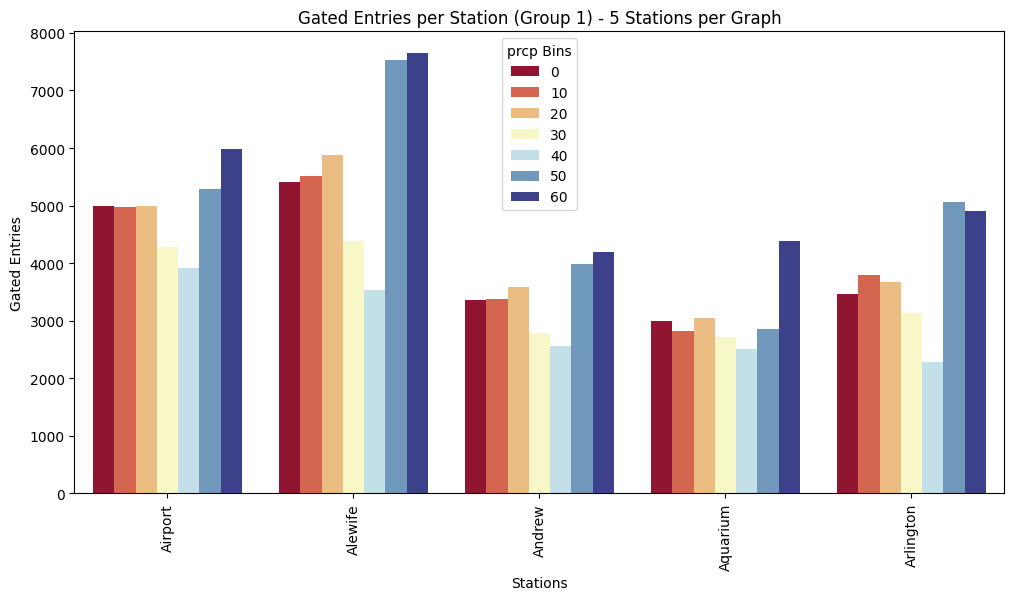

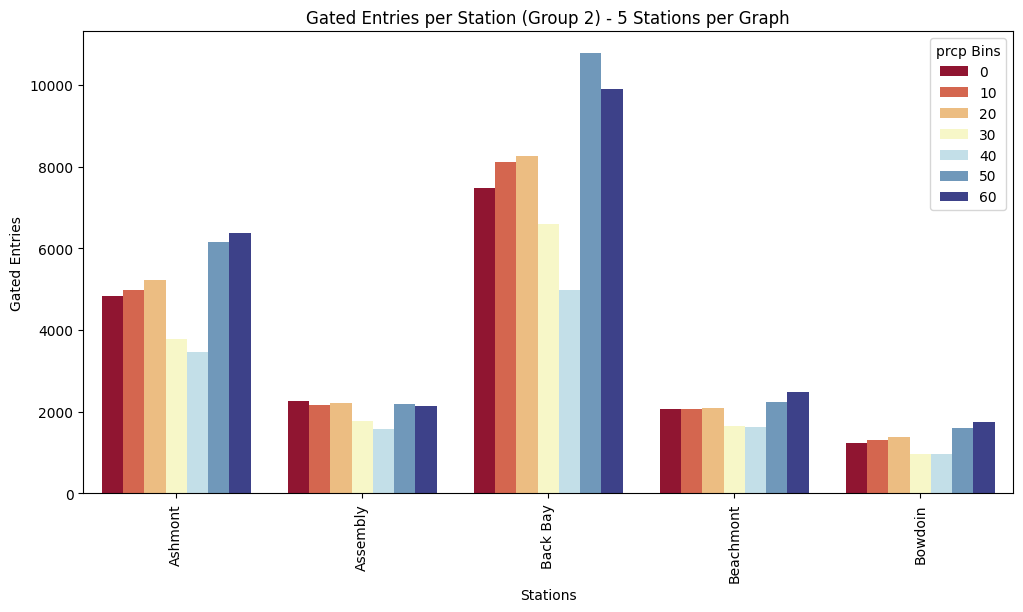

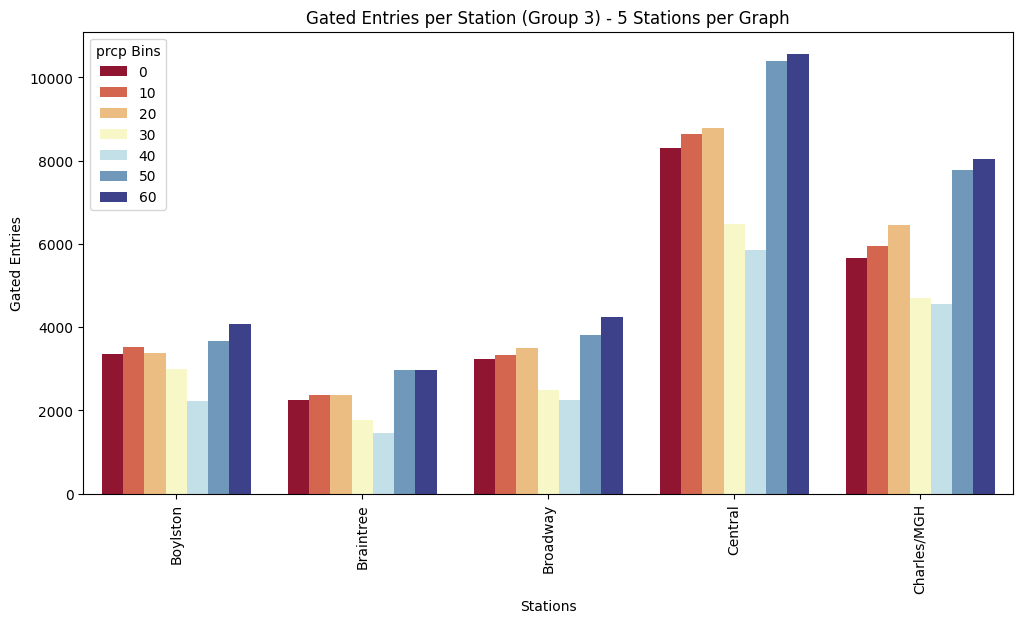

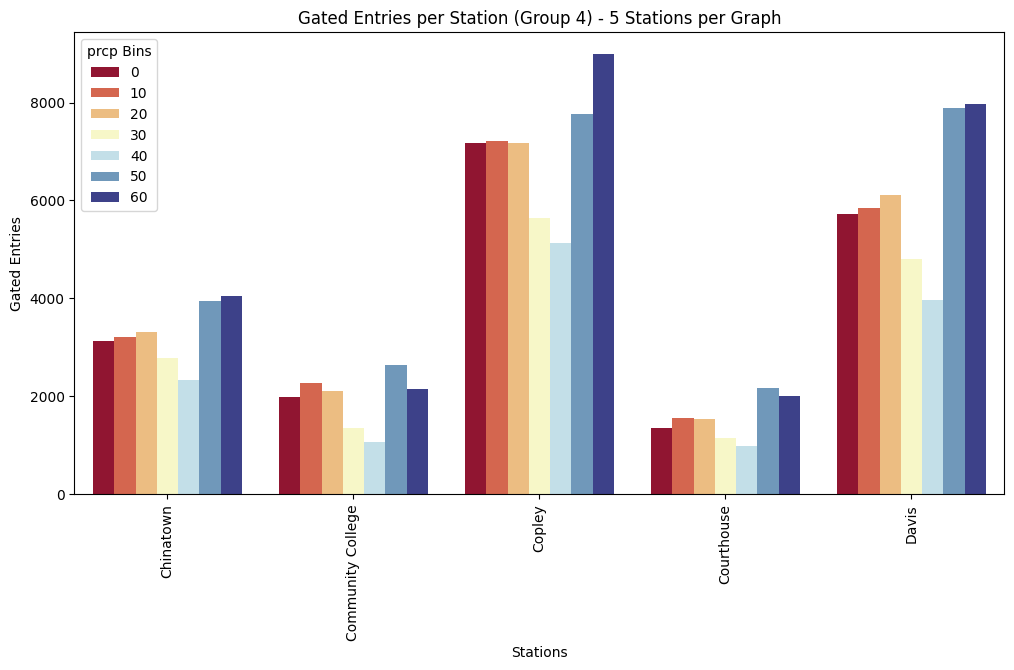

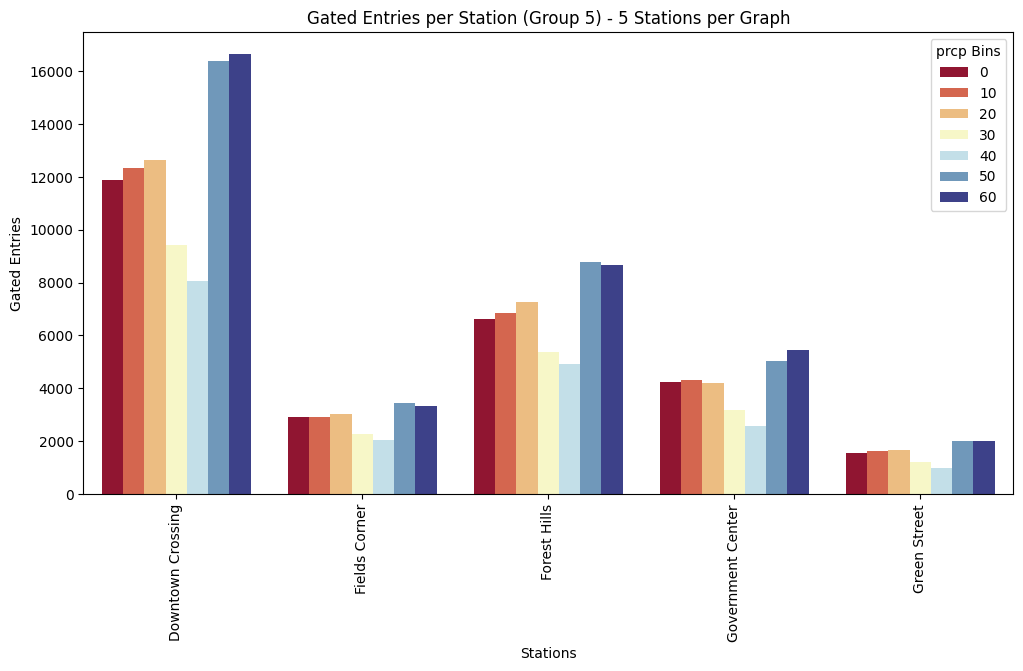

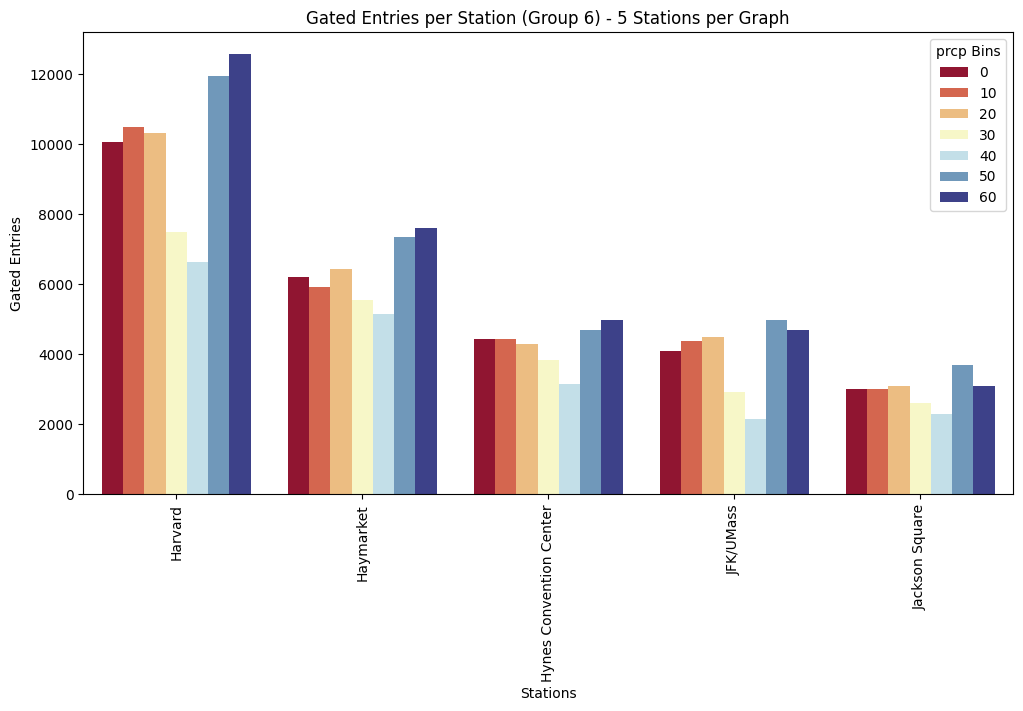

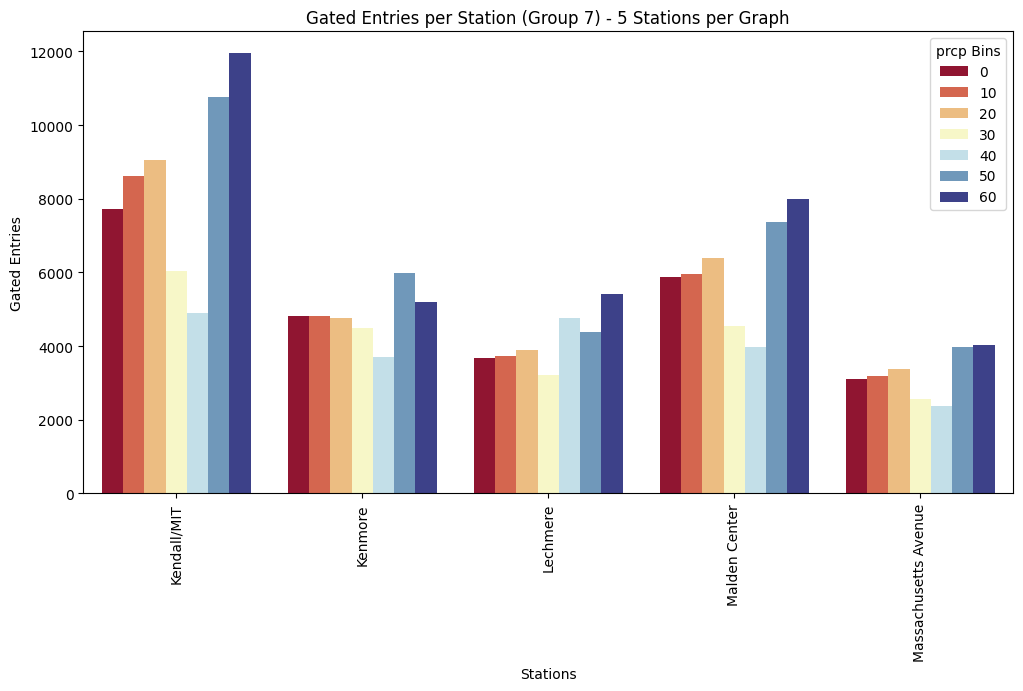

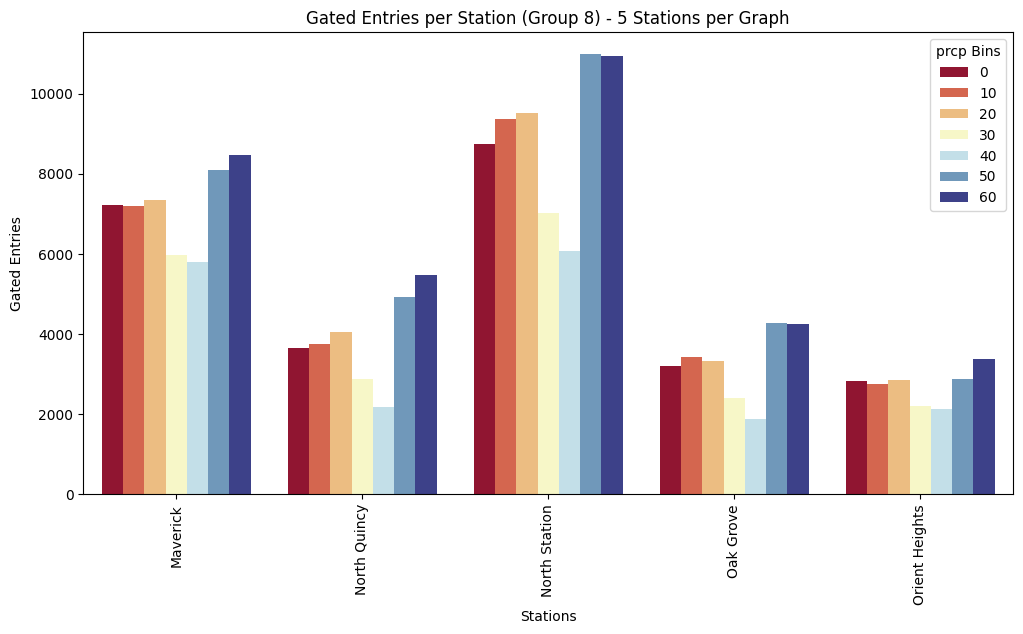

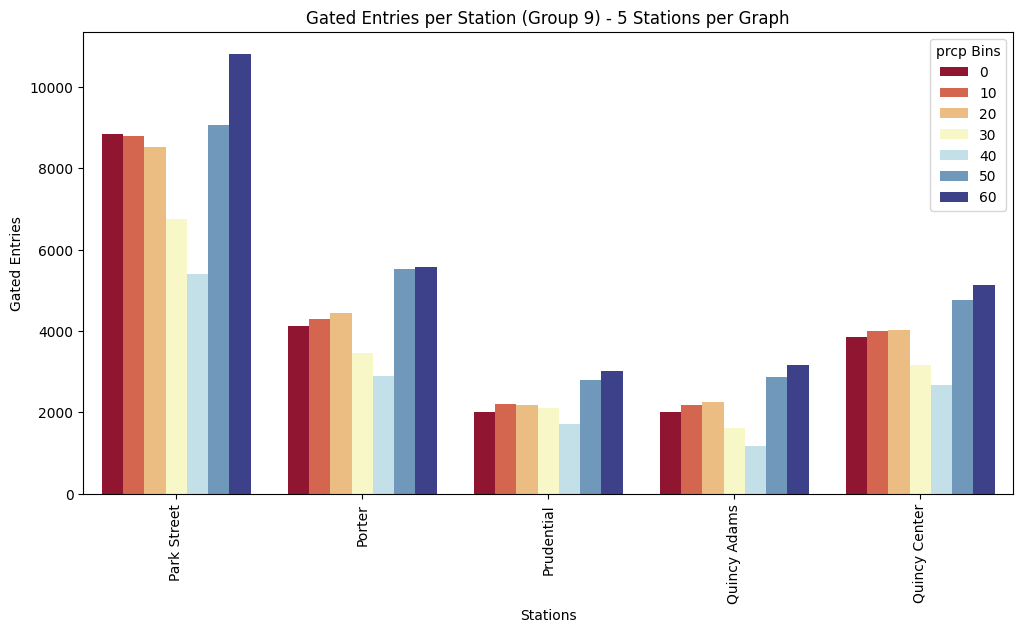

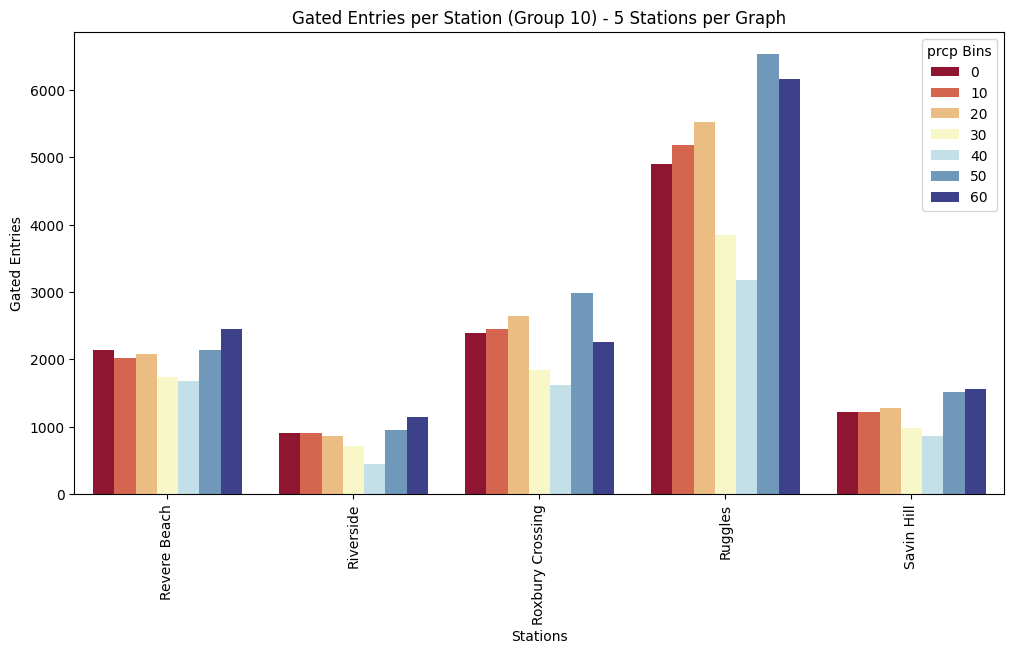

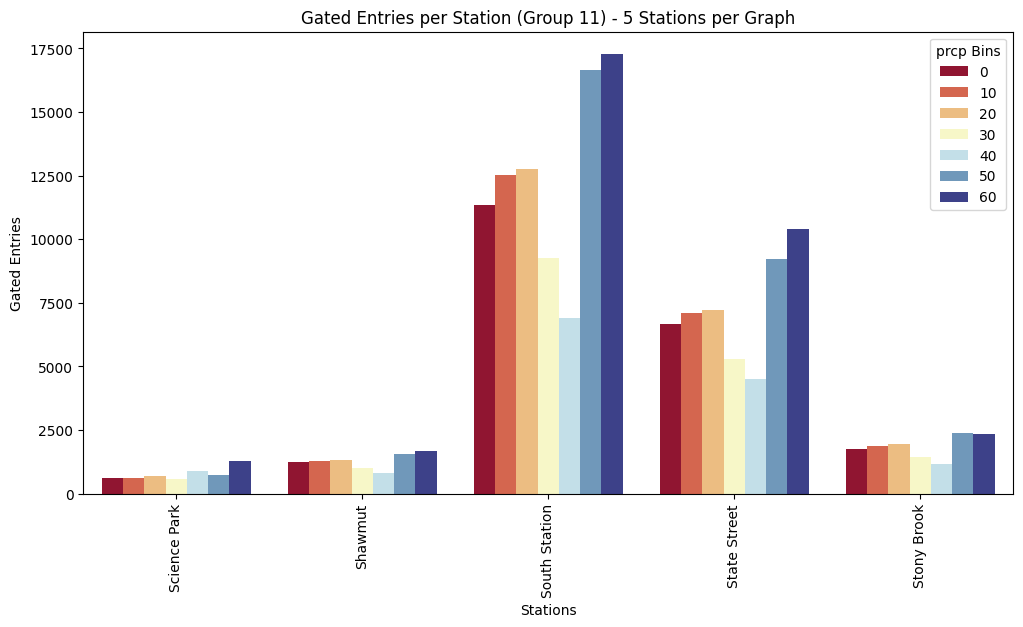

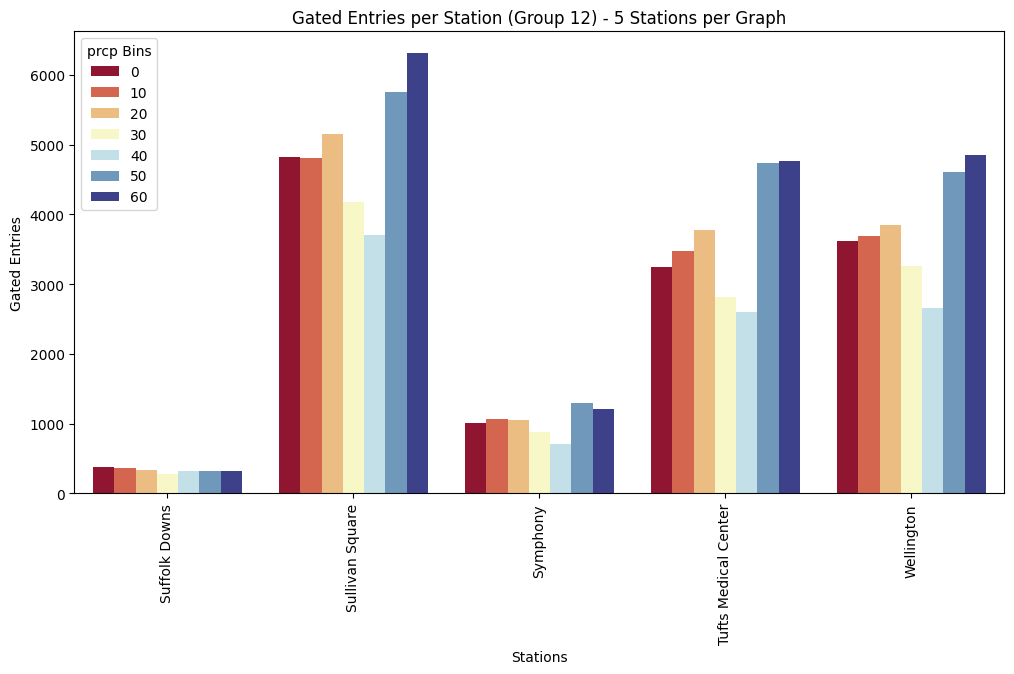

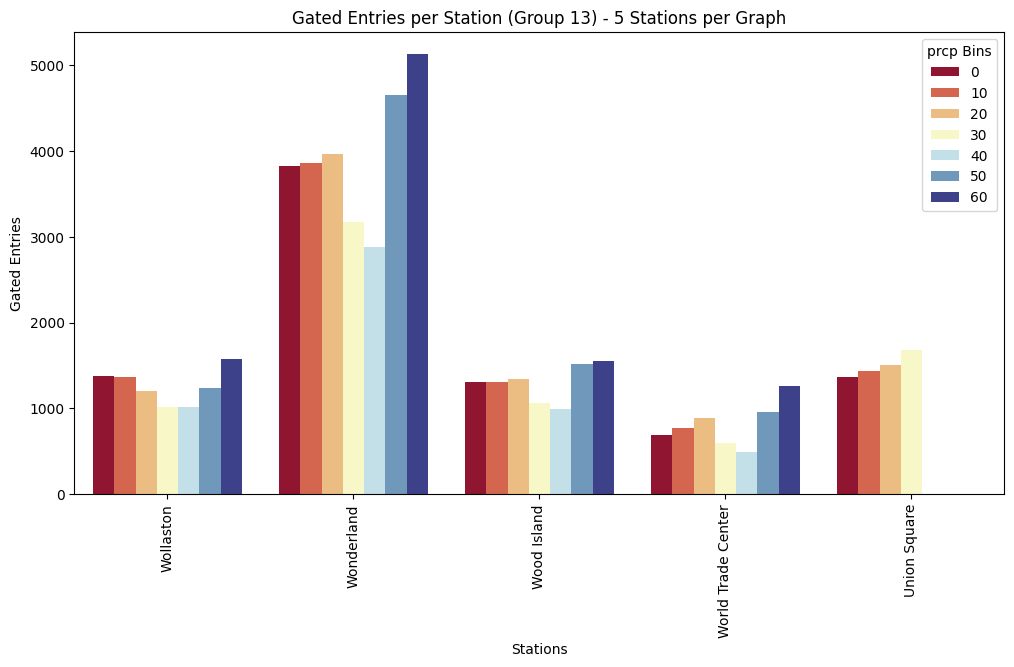

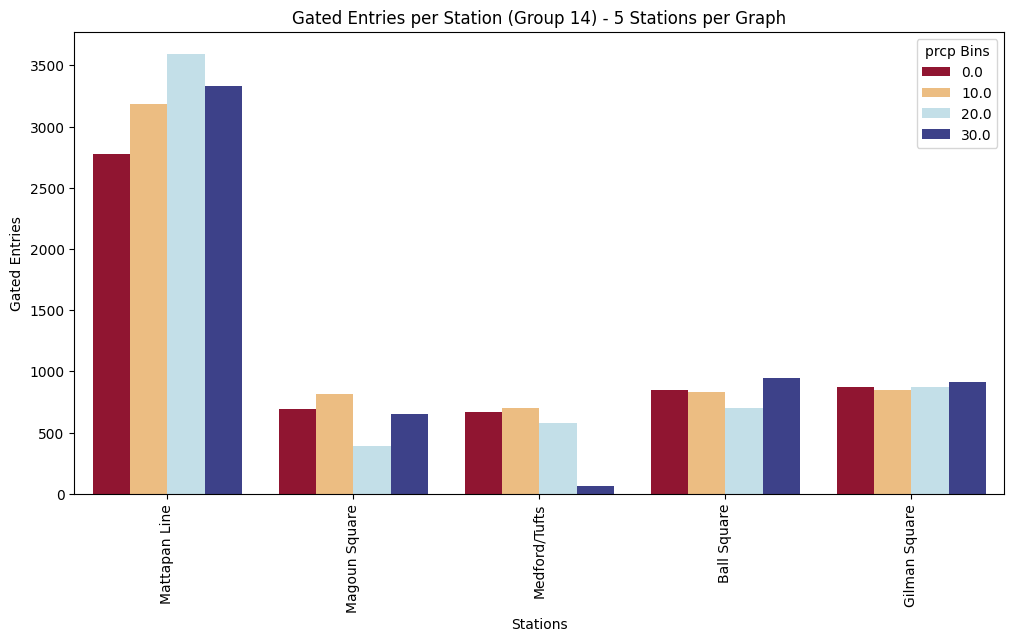

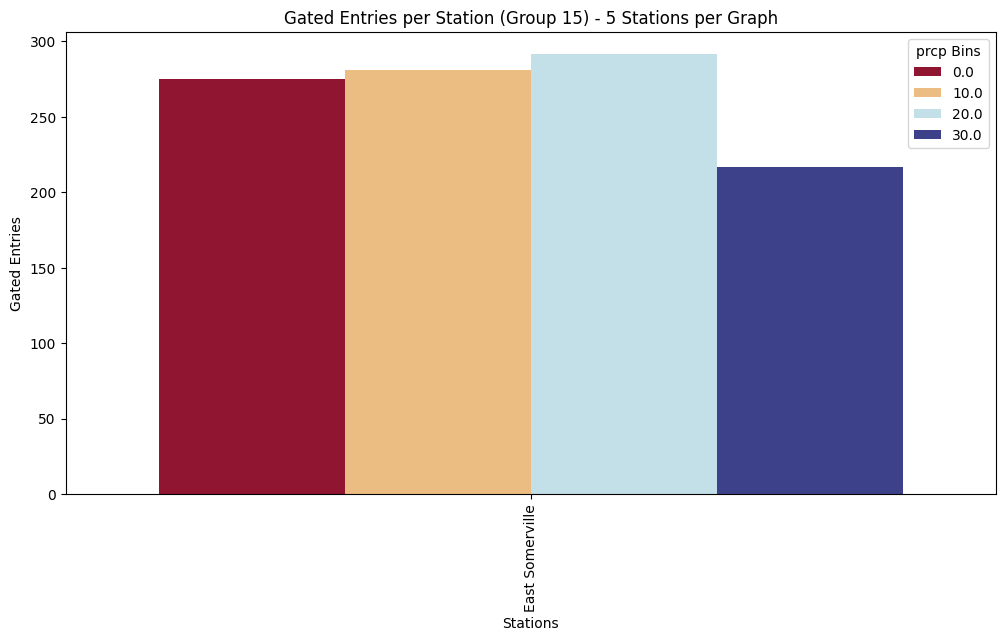

In [27]:
# Create bins for tavg in steps of 10 degrees

df["prcp_bin"] = (df["prcp"] // 10) * 10  # Grouping by 10-degree bins

# Get unique station names
stations = df["station_name"].unique()

# Split stations into chunks of 5c
station_groups = [stations[i:i + 5] for i in range(0, len(stations), 5)]

# Generate multiple graphs, each with 5 stations
for i, group in enumerate(station_groups):
    plt.figure(figsize=(12, 6))  # Set figure size

    # Filter data for the current group of 5 stations
    subset_df = df[df["station_name"].isin(group)]

    # Create bar plot
    sns.barplot(data=subset_df, x="station_name", y="gated_entries", hue="prcp_bin", palette="RdYlBu", errorbar=None)

    # Customize plot
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.xlabel("Stations")
    plt.ylabel("Gated Entries")
    plt.title(f"Gated Entries per Station (Group {i+1}) - 5 Stations per Graph")
    plt.legend(title="prcp Bins")

    # Show plot
    plt.show()

There is a common trend where, during initial precipitation levels (0 to 30mm)—ranging from no rainfall to light rain—people continue commuting as usual. However, at 40mm, due to heavy rainfall, many prefer using cars instead of public transport. At 60mm, during extreme rain or snowstorms, people are more likely to choose trams or public transit over cars due to safety and road conditions.

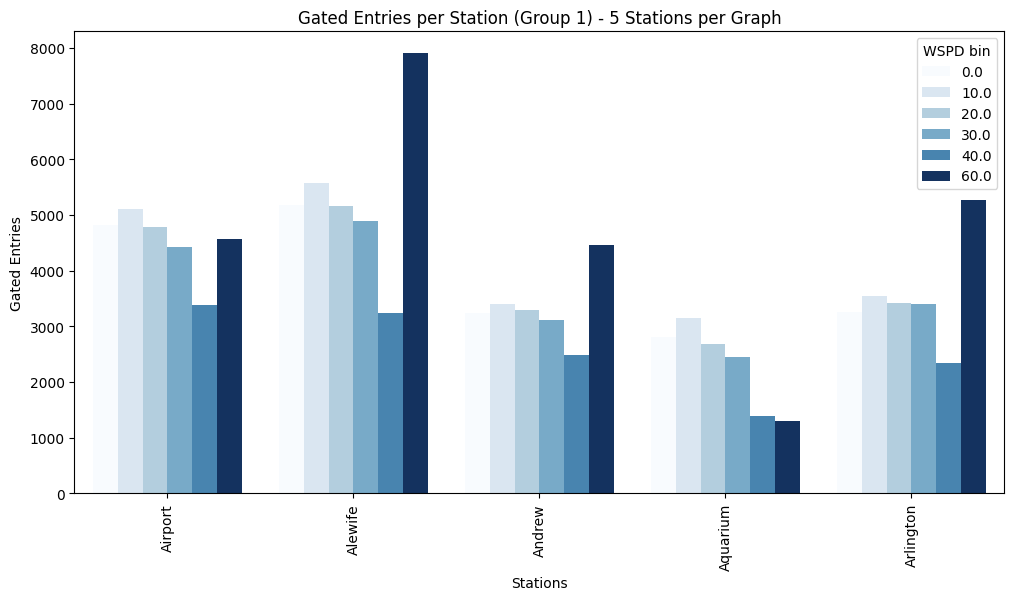

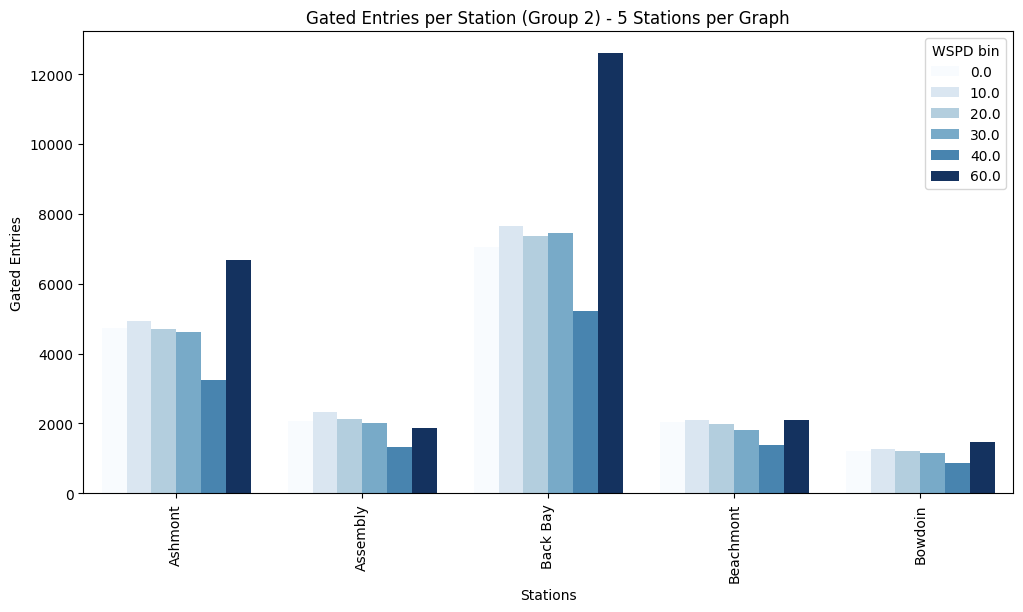

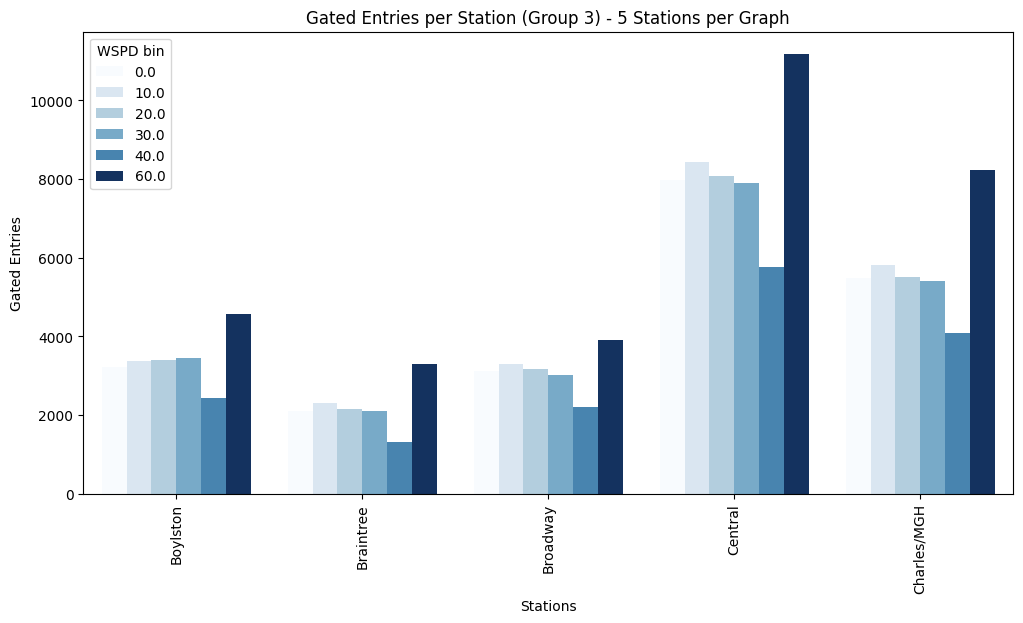

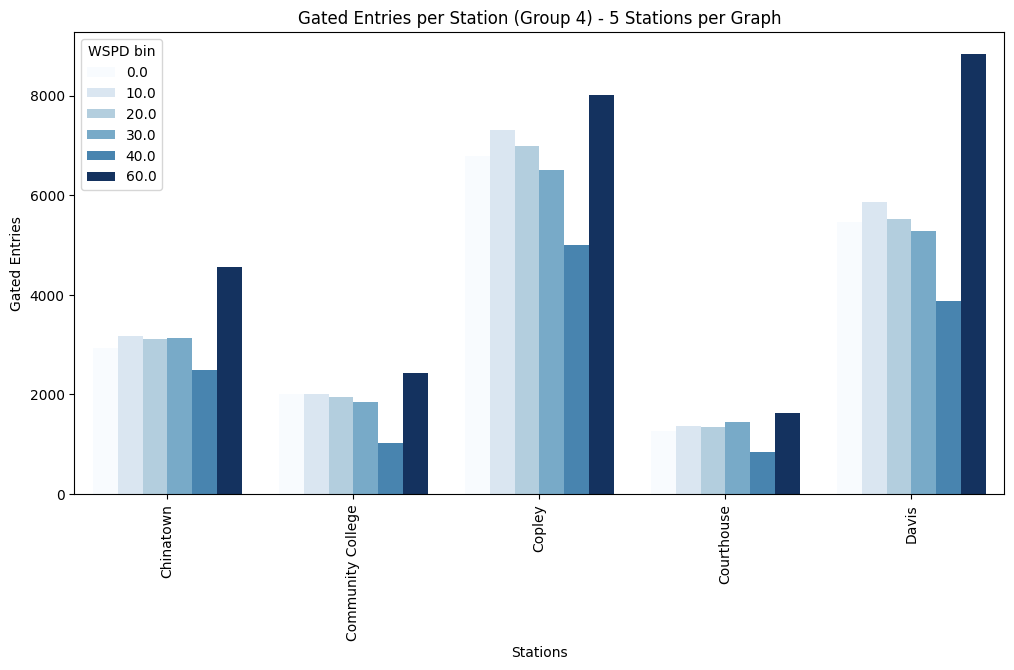

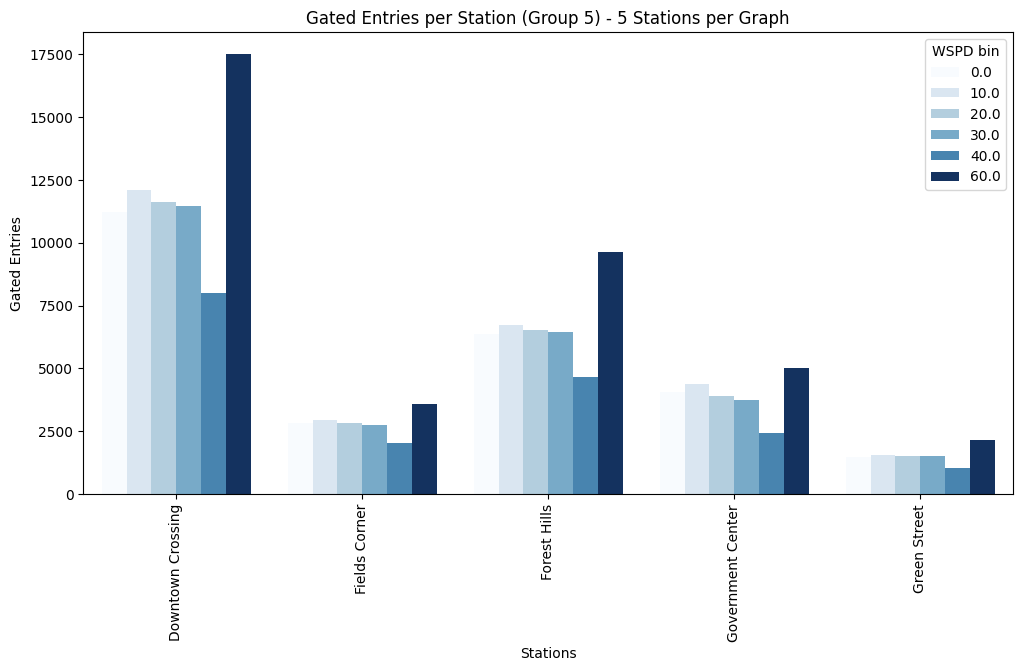

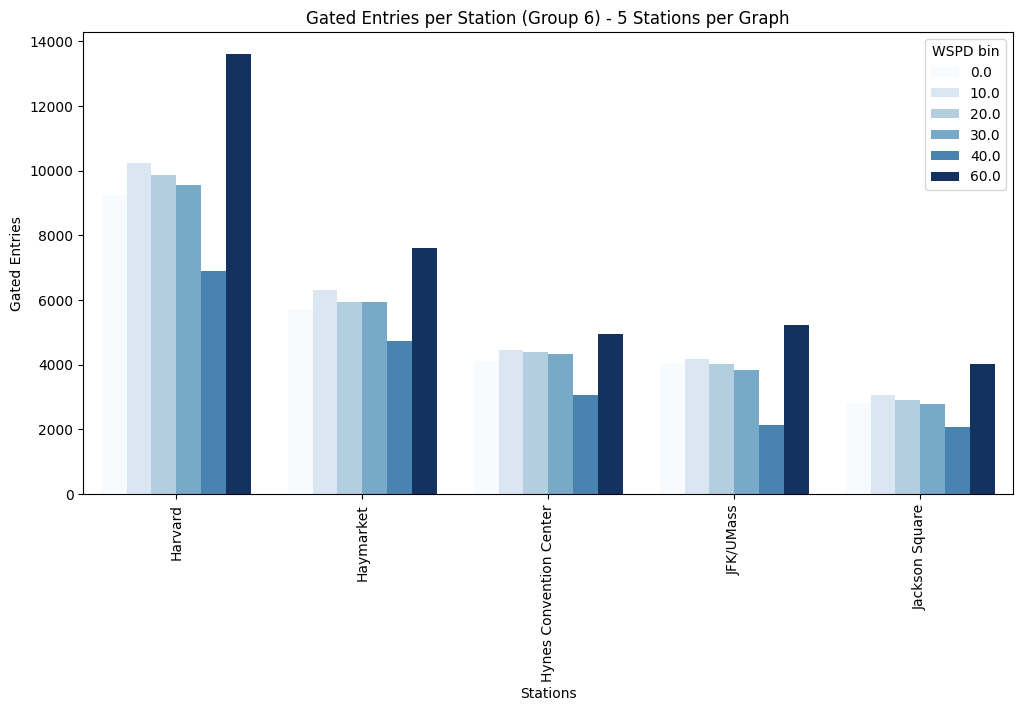

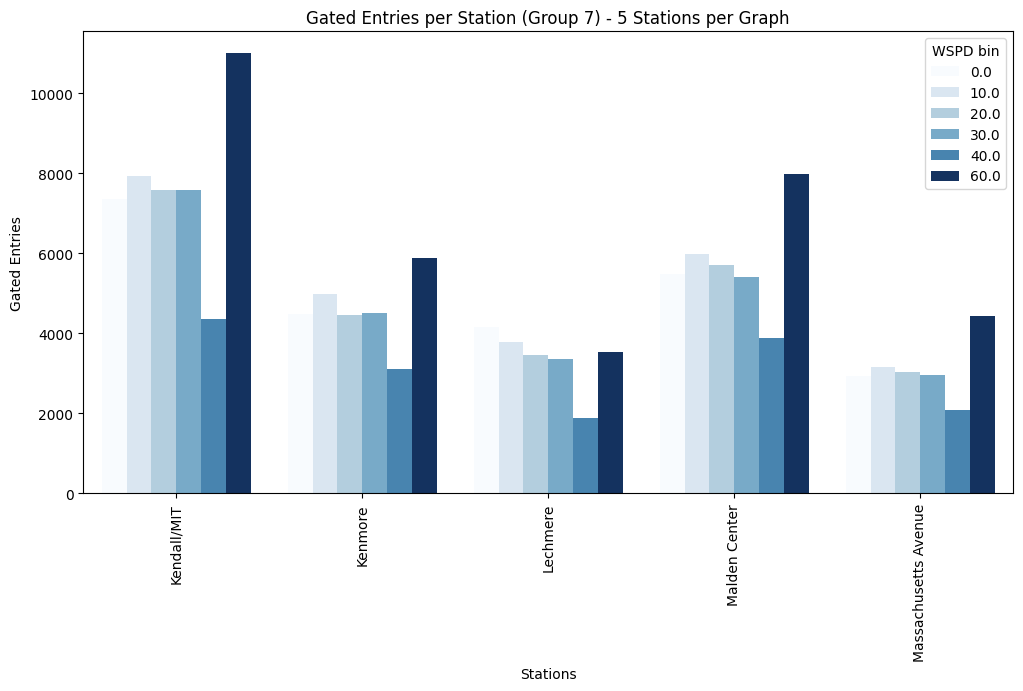

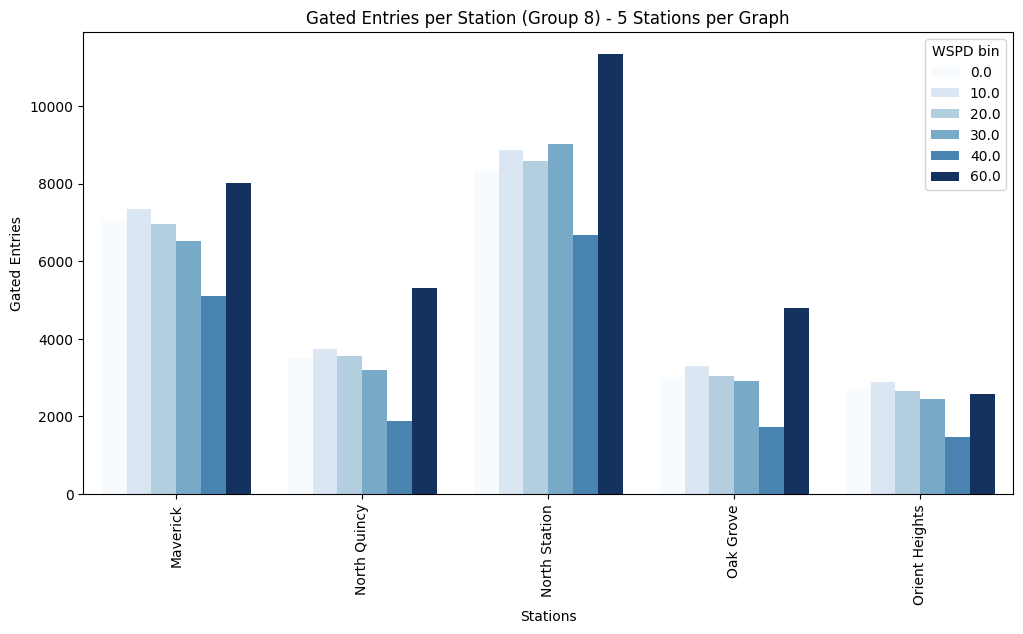

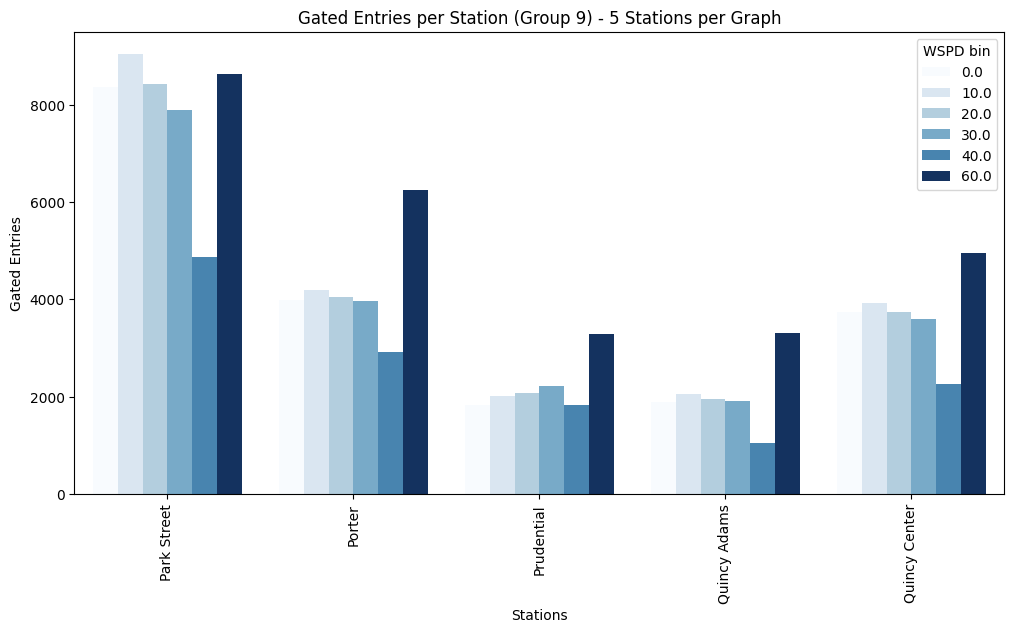

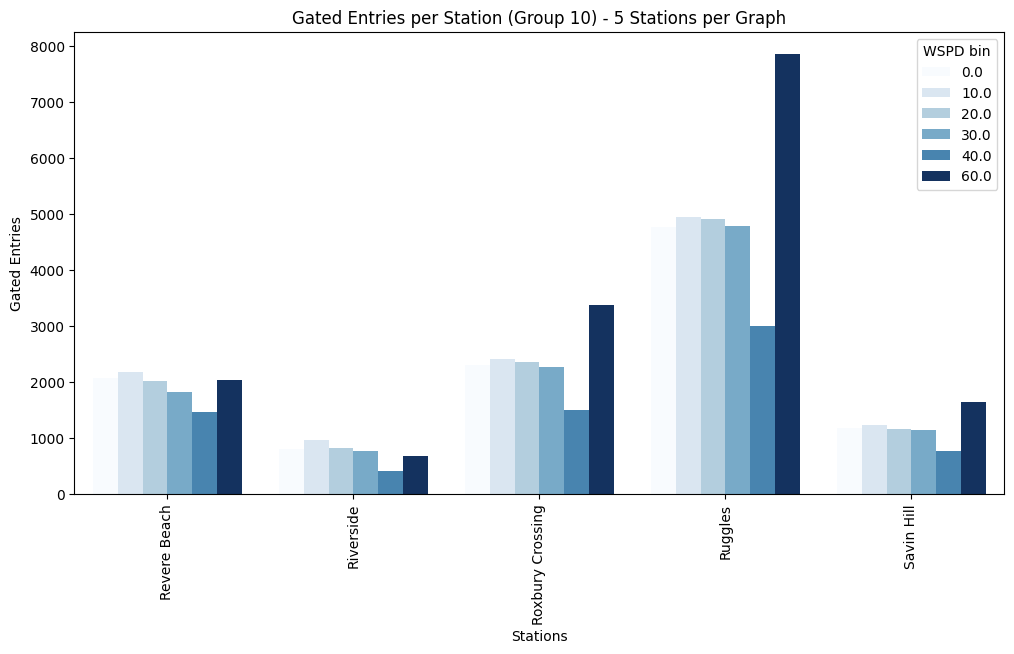

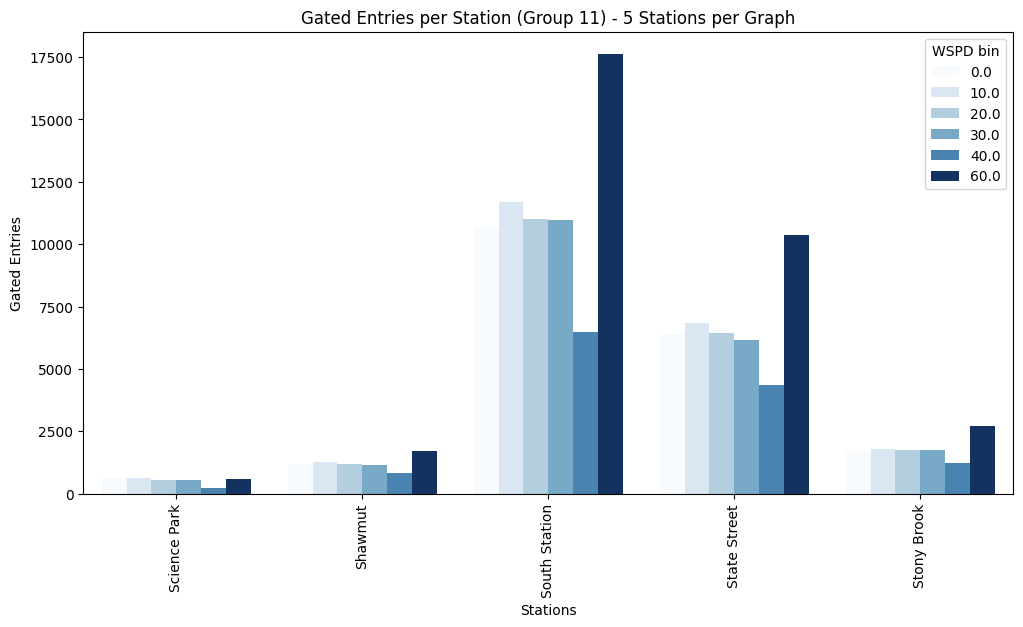

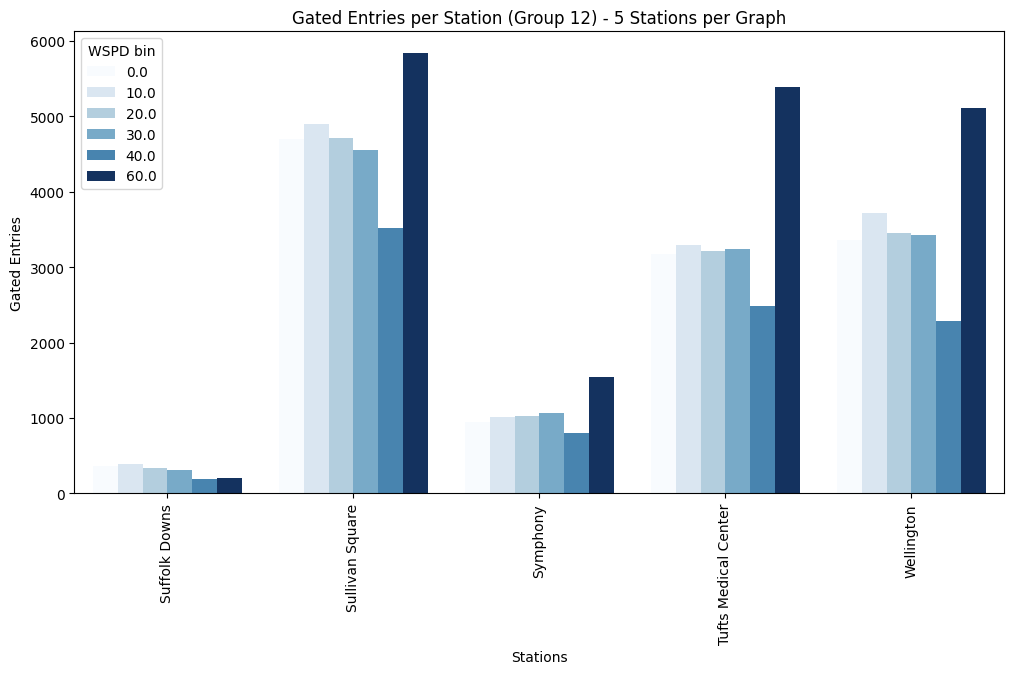

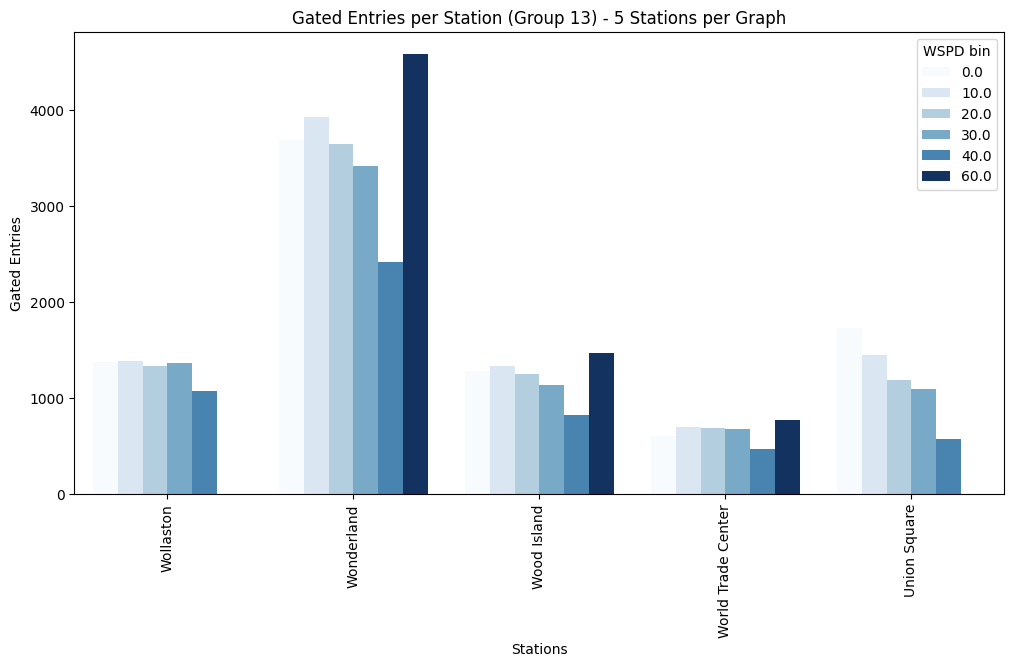

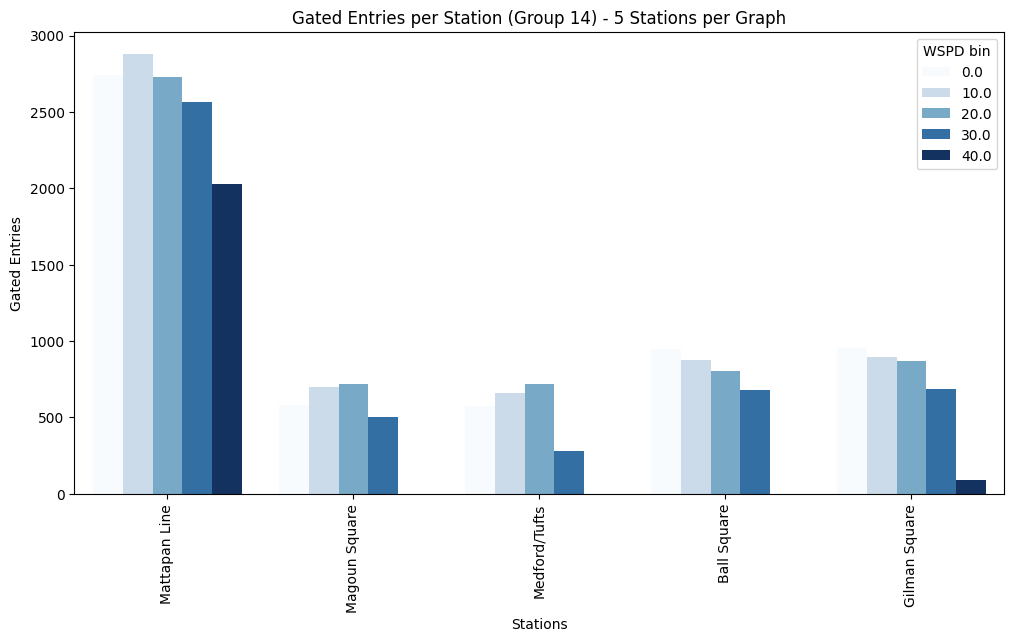

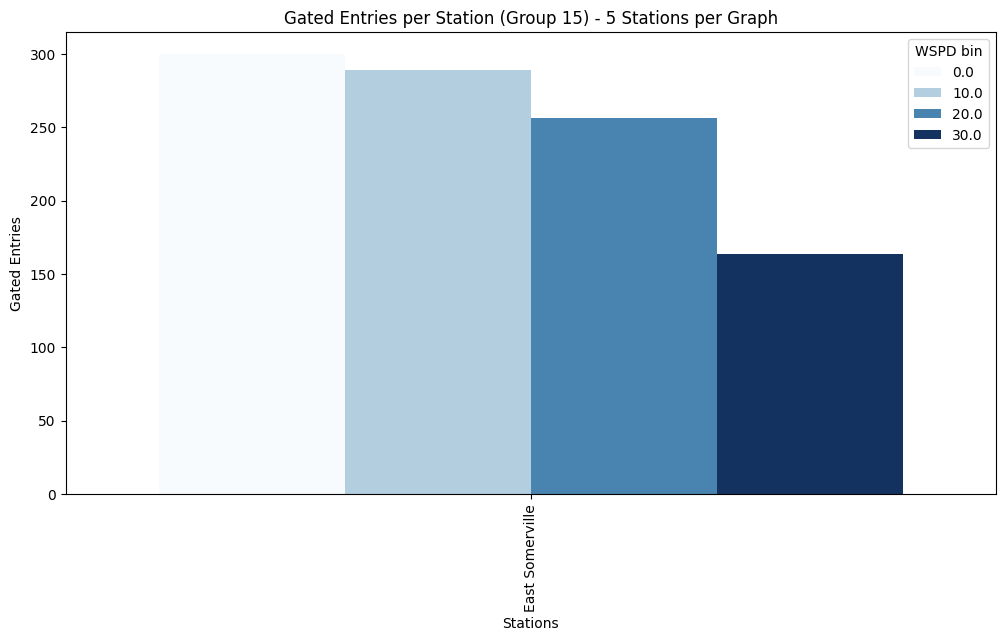

In [28]:
# Create bins for tavg in steps of 10 degrees

df["wspd_bin"] = (df["wspd"] // 10) * 10  # Grouping by 10-degree bins

# Get unique station names
stations = df["station_name"].unique()

# Split stations into chunks of 5c
station_groups = [stations[i:i + 5] for i in range(0, len(stations), 5)]

# Generate multiple graphs, each with 5 stations
for i, group in enumerate(station_groups):
    plt.figure(figsize=(12, 6))  # Set figure size

    # Filter data for the current group of 5 stations
    subset_df = df[df["station_name"].isin(group)]

    # Create bar plot
    sns.barplot(data=subset_df, x="station_name", y="gated_entries", hue="wspd_bin", palette="Blues", errorbar=None)

    # Customize plot
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.xlabel("Stations")
    plt.ylabel("Gated Entries")
    plt.title(f"Gated Entries per Station (Group {i+1}) - 5 Stations per Graph")
    plt.legend(title="WSPD bin")

    # Show plot
    plt.show()

This trend is similar to precipitation patterns, and there is also a correlation with wind conditions.